In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
from statsmodels.tsa.arima.model import ARIMA


%matplotlib inline

pd.set_option('display.max_columns', None)

In [172]:
#Reading in dataframe
df = pd.read_csv('../data/taxi2022.csv')

#Setting the req_index column as the index
df.set_index('req_index', inplace=True)

#Converting the index to datetime
df.index = pd.to_datetime(df.index, format= '%Y-%m-%d')

#Checking the dtypes
df.dtypes

PULocationID            float64
DOLocationID            float64
trip_miles              float64
base_passenger_fare     float64
tips                    float64
driver_pay              float64
congestion_surcharge    float64
req_time                 object
req_date                 object
pickup_time              object
dropoff_date             object
dropoff_time             object
temp                    float64
preciptype                int64
zone                     object
borough                   int64
dtype: object

In [173]:
#Looking to see if anything seems weird
df.describe()

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,temp,preciptype,borough
count,3.975858e+06,3.975858e+06,3.975858e+06,3.975858e+06,3.975858e+06,3.975858e+06,3.975858e+06,3.975858e+06,3.975858e+06,3.975858e+06
mean,1.388804e+02,1.425236e+02,5.082325e+00,2.368941e+01,1.096066e+00,1.868563e+01,1.056550e+00,5.722610e+01,8.456776e-01,2.640150e+00
std,7.486002e+01,7.774033e+01,5.885739e+00,1.985214e+01,3.061492e+00,1.536080e+01,1.340531e+00,1.754741e+01,1.031638e+00,1.028340e+00
min,2.000000e+00,1.000000e+00,0.000000e+00,-1.053600e+02,0.000000e+00,-6.705000e+01,0.000000e+00,1.660000e+01,0.000000e+00,0.000000e+00
25%,7.500000e+01,7.600000e+01,1.620000e+00,1.143000e+01,0.000000e+00,8.800000e+00,0.000000e+00,4.320000e+01,0.000000e+00,2.000000e+00
50%,1.400000e+02,1.410000e+02,3.040000e+00,1.808000e+01,0.000000e+00,1.432000e+01,0.000000e+00,5.770000e+01,1.000000e+00,2.000000e+00
75%,2.110000e+02,2.170000e+02,6.340000e+00,2.911000e+01,0.000000e+00,2.339000e+01,2.750000e+00,7.290000e+01,1.000000e+00,4.000000e+00
max,2.650000e+02,2.650000e+02,4.642000e+02,1.448910e+03,1.678500e+02,1.088710e+03,5.500000e+00,8.740000e+01,6.000000e+00,5.000000e+00


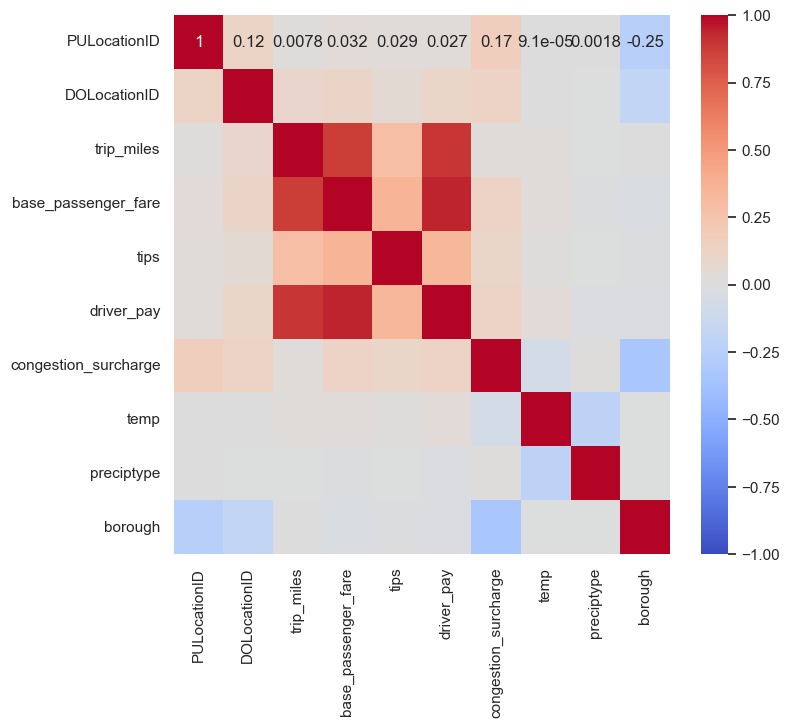

In [174]:
#Taking a look at correlations between features
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,7))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='coolwarm');

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


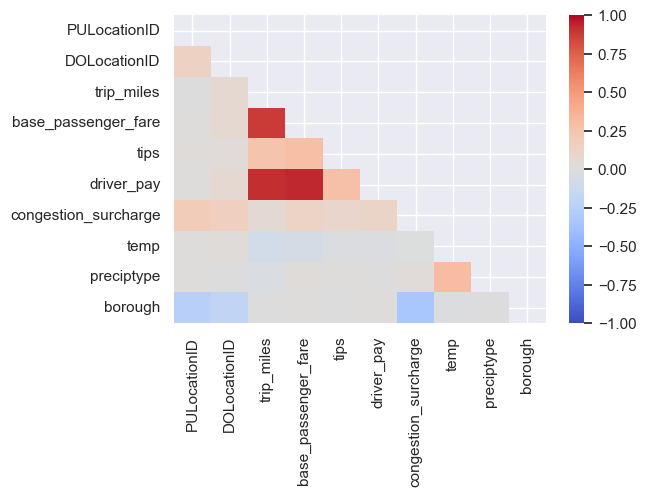

In [91]:
#Seeing if this changes at all by month

#Looking and plotting just january data
jan = df.loc['2022-01']
jan_corr = jan.corr(numeric_only=True)

plt.figure(figsize=(6,4))
mask = np.triu(np.ones_like(jan_corr, dtype=bool))
sns.heatmap(jan_corr, annot=True, vmin=-1, vmax=1, mask=mask, fmt=".1f", cmap='coolwarm');

In [92]:
#How much, on average, does a driver make per trip by per month
df['driver_pay'].resample("ME").mean()

req_index
2022-01-31    15.765004
2022-02-28    16.843190
2022-03-31    17.874964
2022-04-30    19.431766
2022-05-31    19.508241
2022-06-30    19.272946
2022-07-31    18.104166
2022-08-31    18.679815
2022-09-30    19.781683
2022-10-31    20.361846
2022-11-30    18.485168
2022-12-31    19.566540
Freq: ME, Name: driver_pay, dtype: float64

In [186]:
df['month'] = pd.to_datetime(df['req_date']).dt.month

In [187]:
df['day'] = pd.to_datetime(df['req_date']).dt.day

In [95]:
df['day'].unique()

array([ 4,  6,  8, 10, 13, 15, 18, 20, 22, 24, 26, 28, 30,  3,  5, 12, 19,
       21, 23, 25,  2,  7,  9, 11, 14, 17, 27, 29, 31], dtype=int32)

In [226]:
hoods = {0 : 'missing', 1: 'Bronx', 2: 'Manhattan', 3: 'Queens', 
          4: 'Brooklyn', 5: 'Staten Island'}
df['borough_name'] = df['borough'].map(hoods)
df.head()

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,tips_driver_pay,trip_duration,month,day,borough_name
req_index,,,,,,,,,,,,,,,,,,,,,
2022-01-04,183.0,20.0,4.148,17.69,4.95,12.13,0.00,07:32:25,2022-01-04,07:38:00,2022-01-04,07:53:00,27.6,0,Pelham Bay,1,17.08,900,1,4,Bronx
2022-01-04,262.0,238.0,1.630,10.11,0.00,7.68,2.75,07:15:54,2022-01-04,07:17:00,2022-01-04,07:29:00,27.6,0,Yorkville East,2,7.68,720,1,4,Manhattan
2022-01-04,50.0,161.0,1.751,10.05,2.00,7.85,2.75,07:15:54,2022-01-04,07:23:00,2022-01-04,07:32:00,27.6,0,Clinton West,2,9.85,540,1,4,Manhattan
2022-01-04,124.0,124.0,1.633,10.76,0.00,5.47,0.00,07:15:54,2022-01-04,07:23:00,2022-01-04,07:28:00,27.6,0,Howard Beach,3,5.47,300,1,4,Queens
2022-01-04,180.0,63.0,6.070,24.41,0.00,16.33,0.00,07:15:54,2022-01-04,07:19:00,2022-01-04,07:38:00,27.6,0,Ozone Park,3,16.33,1140,1,4,Queens


In [96]:
avg_trip_pay_day = df['driver_pay'].groupby(df['day']).mean()

In [ ]:
model = ARIMA(df['tips_driver_pay'], order=(1, 1, 1))
a = model.fit()
three_months = a.forecast(steps=3)

plt.plot(df.index, df['tips_driver_pay']

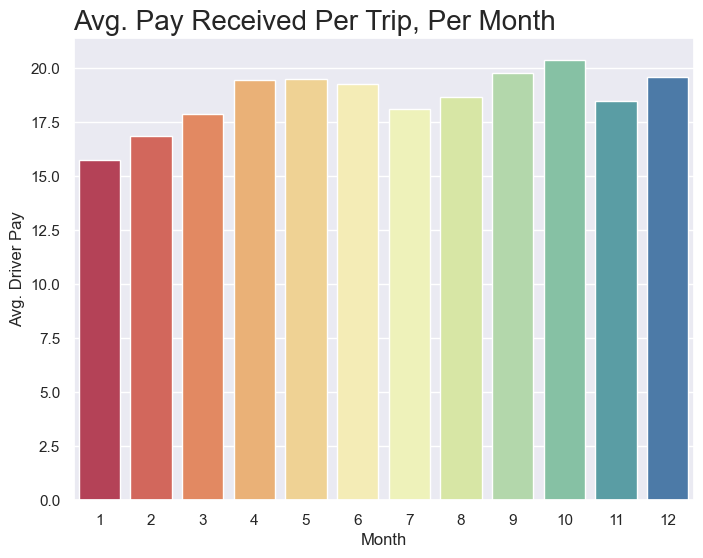

In [97]:
plt.figure(figsize=(8,6))
sns.color_palette("Spectral", as_cmap=True)
sns.barplot(x=df['month'].unique(), y=df['driver_pay'].resample("ME").mean(), palette='Spectral');
plt.ylabel("Avg. Driver Pay")
plt.xlabel("Month")
plt.title("Avg. Pay Received Per Trip, Per Month", loc='left', fontsize=20);

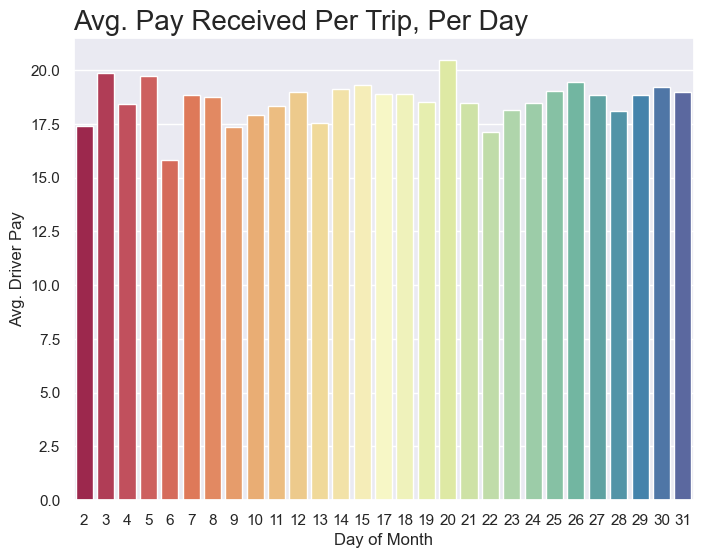

In [98]:
plt.figure(figsize=(8,6))
sns.color_palette("Spectral", as_cmap=True)
sns.barplot(x=df['day'].unique(), y=avg_trip_pay_day, palette='Spectral');
plt.ylabel("Avg. Driver Pay")
plt.xlabel("Day of Month")
plt.title("Avg. Pay Received Per Trip, Per Day", loc='left', fontsize=20);

In [99]:
pay_by_borough = df[['driver_pay', 'borough', 'month']]
pay_by_borough['driver_pay'].resample("ME").mean()

#Avg trip revenue by borough, by month

req_index
2022-01-31    15.765004
2022-02-28    16.843190
2022-03-31    17.874964
2022-04-30    19.431766
2022-05-31    19.508241
2022-06-30    19.272946
2022-07-31    18.104166
2022-08-31    18.679815
2022-09-30    19.781683
2022-10-31    20.361846
2022-11-30    18.485168
2022-12-31    19.566540
Freq: ME, Name: driver_pay, dtype: float64

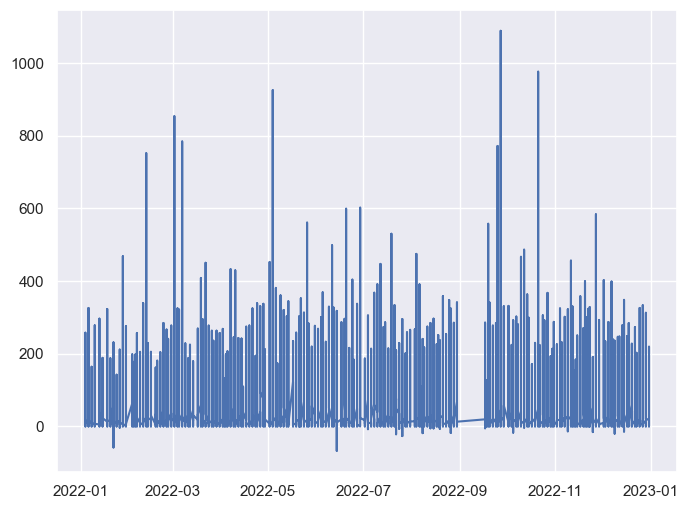

In [193]:
plt.figure(figsize=(8,6))
plt.plot(df.index, df['tips_driver_pay'])

In [200]:
df.columns

Index(['PULocationID', 'DOLocationID', 'trip_miles', 'base_passenger_fare',
       'tips', 'driver_pay', 'congestion_surcharge', 'req_time', 'req_date',
       'pickup_time', 'dropoff_date', 'dropoff_time', 'temp', 'preciptype',
       'zone', 'borough', 'tips_driver_pay', 'trip_duration', 'month', 'day'],
      dtype='object')

In [225]:
df_weekly = df.resample('W')
df_weekly

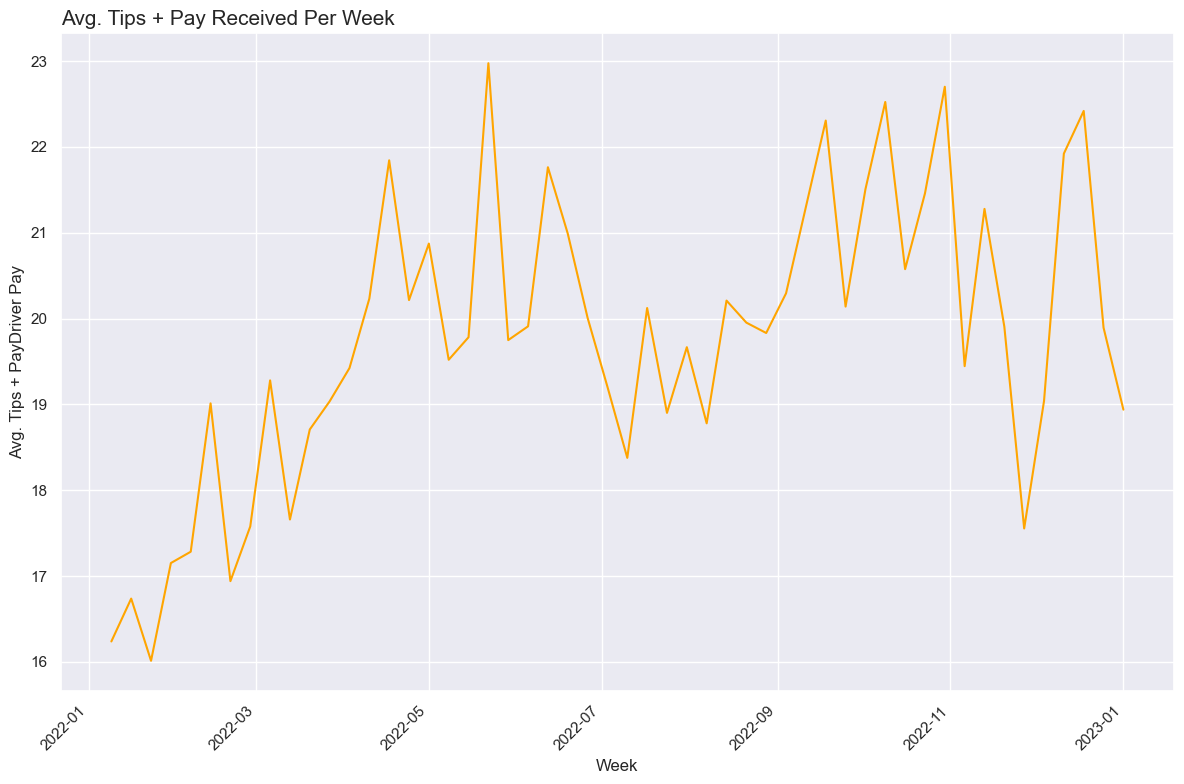

In [230]:
plt.figure(figsize=(12,8))
plt.plot(df_weekly['tips_driver_pay'].resample('W').mean(), color='orange')
plt.ylabel("Avg. Tips + PayDriver Pay")
plt.xlabel("Week")
plt.title("Avg. Tips + Pay Received Per Week", loc='left', fontsize=15);

plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.tight_layout() 

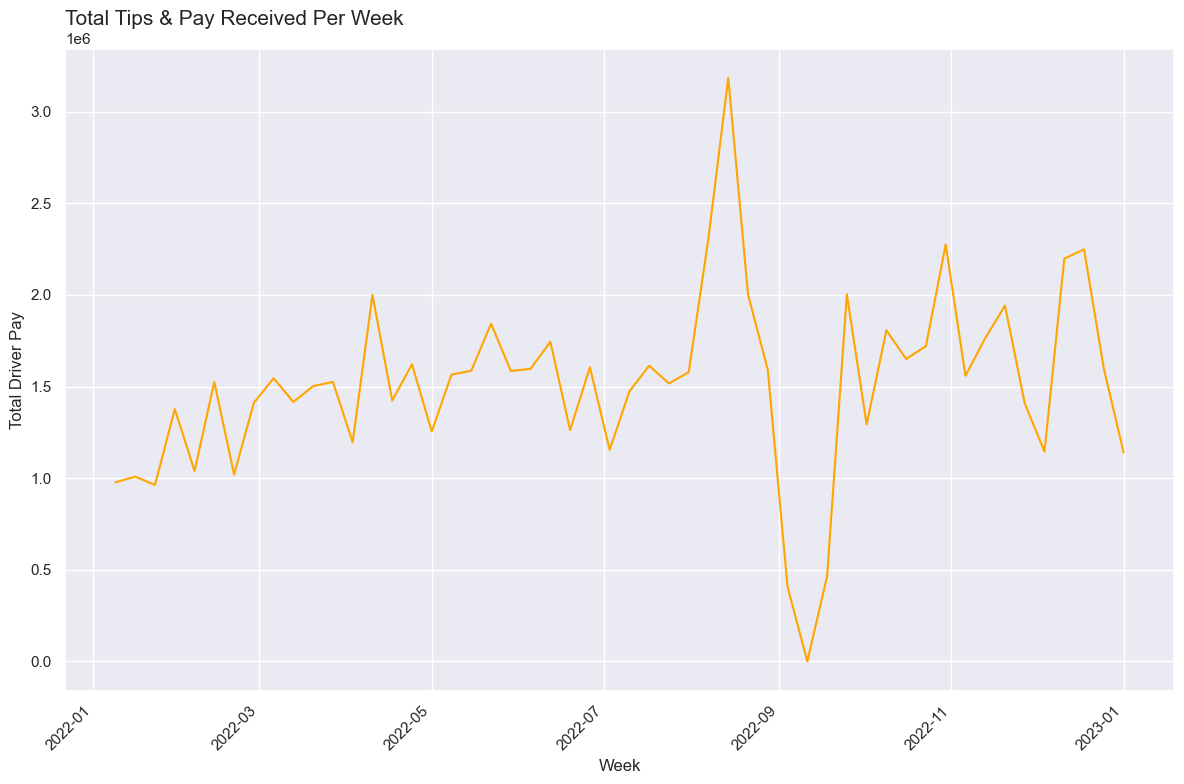

In [242]:
plt.figure(figsize=(12,8))
plt.plot(df['tips_driver_pay'].resample('W').sum(), color='orange')
plt.ylabel("Total Driver Pay")
plt.xlabel("Week")
plt.title("Total Tips & Pay Received Per Week", loc='left', fontsize=15);

plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.tight_layout() 

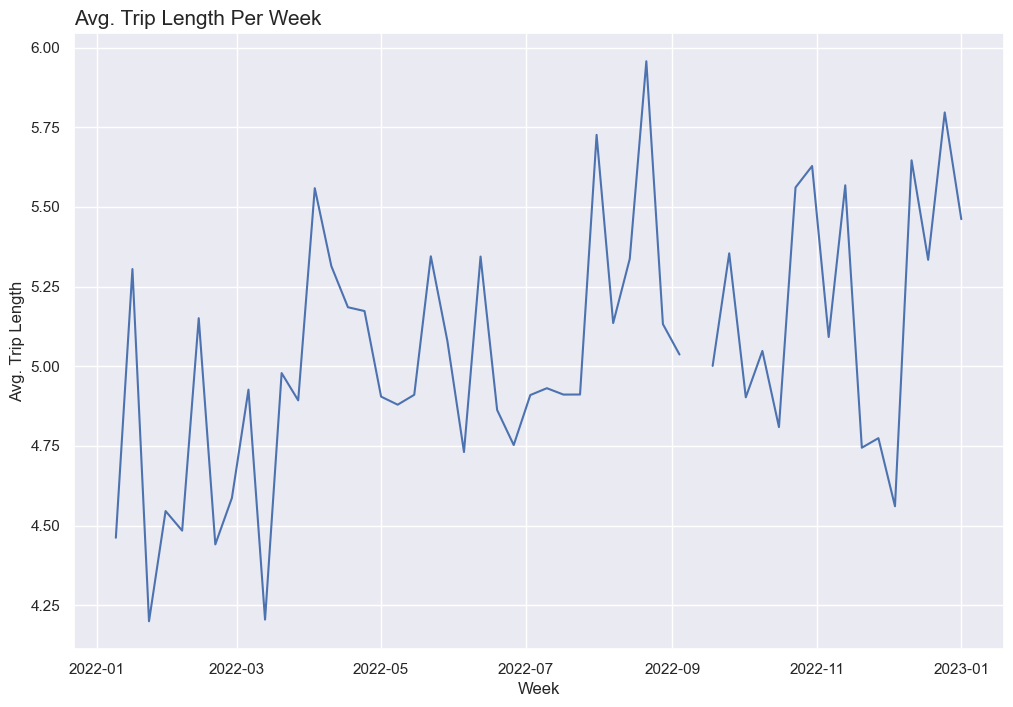

In [257]:
plt.figure(figsize=(12,8))
plt.plot(df['trip_miles'].resample('W').mean())
plt.ylabel("Avg. Trip Length")
plt.xlabel("Week")
plt.title("Avg. Trip Length Per Week", loc='left', fontsize=15);

In [100]:
{'missing': 0, 'Bronx': 1, 'Manhattan': 2, 'Queens': 3, 
          'Brooklyn': 4, 'Staten Island': 5} 

{'missing': 0,
 'Bronx': 1,
 'Manhattan': 2,
 'Queens': 3,
 'Brooklyn': 4,
 'Staten Island': 5}

In [101]:
unknown = df[df['borough'] == 0]
bronx = df[df['borough'] == 1]
man = df[df['borough'] == 2]
qu = df[df['borough'] == 3]
br = df[df['borough'] == 4]
si = df[df['borough'] == 5]

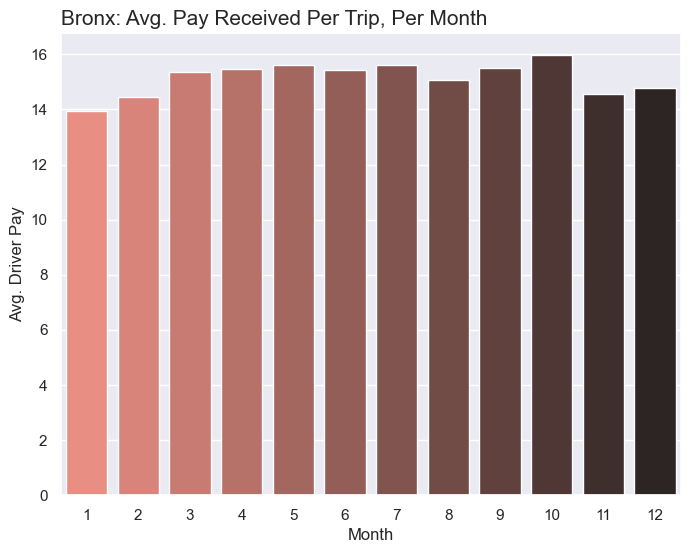

In [102]:
plt.figure(figsize=(8,6))
sns.color_palette("dark:salmon_r", as_cmap=True)
sns.barplot(data=bronx, x=bronx['month'].unique(), y=bronx['driver_pay'].resample("ME").mean(), palette="dark:salmon_r", estimator=np.mean);
plt.ylabel("Avg. Driver Pay")
plt.xlabel("Month")
plt.title("Bronx: Avg. Pay Received Per Trip, Per Month", loc='left', fontsize=15);

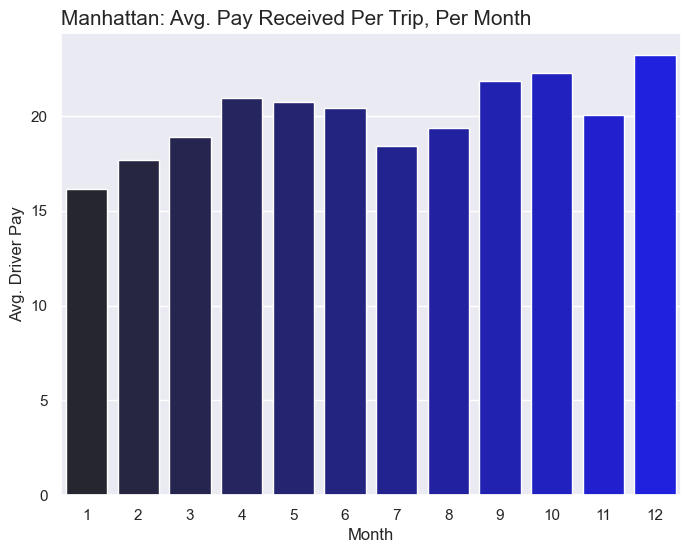

In [103]:
plt.figure(figsize=(8,6))
sns.color_palette("dark:Blue", as_cmap=True)
sns.barplot(data=man, x=man['month'].unique(), y=man['driver_pay'].resample("ME").mean(), palette="dark:Blue", estimator=np.mean);
plt.ylabel("Avg. Driver Pay")
plt.xlabel("Month")
plt.title("Manhattan: Avg. Pay Received Per Trip, Per Month", loc='left', fontsize=15);

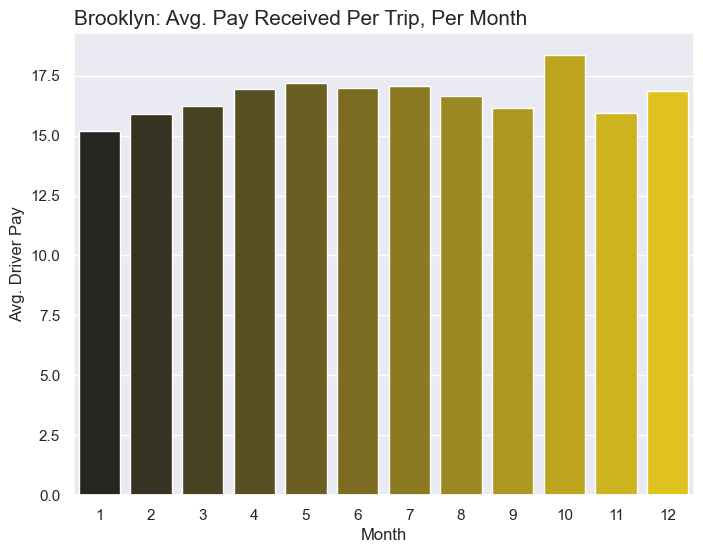

In [104]:
plt.figure(figsize=(8,6))
sns.color_palette("dark:Gold", as_cmap=True)
sns.barplot(data=br, x=br['month'].unique(), y=br['driver_pay'].resample("ME").mean(), palette="dark:Gold", estimator=np.mean);
plt.ylabel("Avg. Driver Pay")
plt.xlabel("Month")
plt.title("Brooklyn: Avg. Pay Received Per Trip, Per Month", loc='left', fontsize=15);

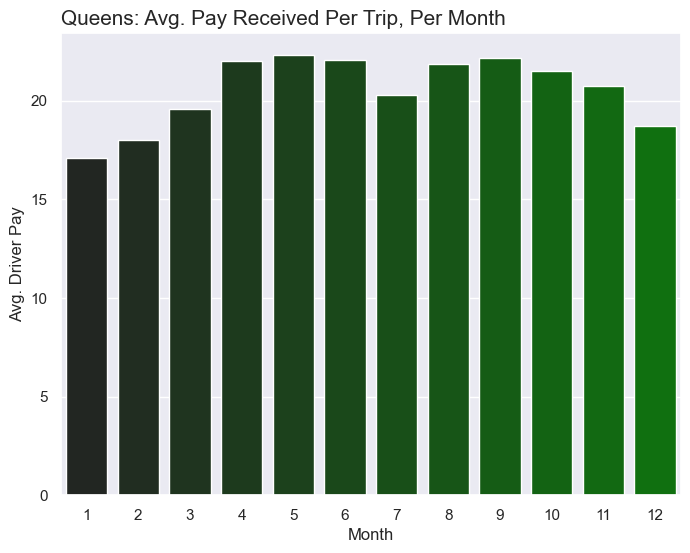

In [105]:
plt.figure(figsize=(8,6))
sns.color_palette("dark:Green", as_cmap=True)
sns.barplot(data=qu, x=qu['month'].unique(), y=qu['driver_pay'].resample("ME").mean(), palette="dark:Green", estimator=np.mean);
plt.ylabel("Avg. Driver Pay")
plt.xlabel("Month")
plt.title("Queens: Avg. Pay Received Per Trip, Per Month", loc='left', fontsize=15);

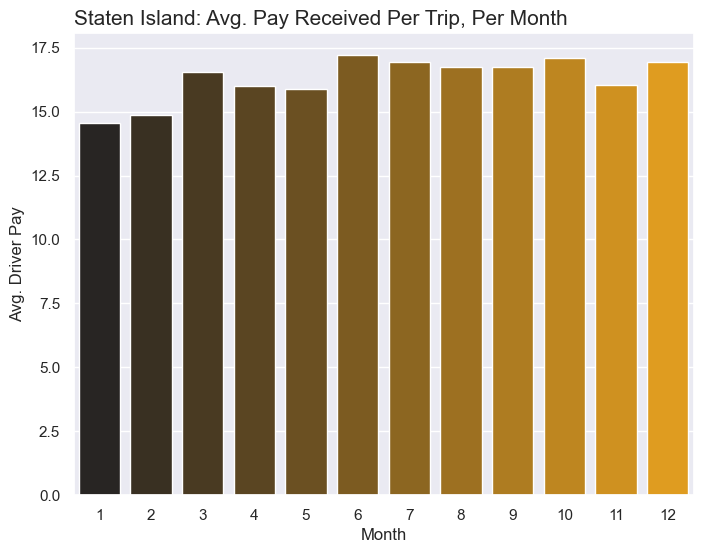

In [106]:
plt.figure(figsize=(8,6))
sns.color_palette("dark:Orange", as_cmap=True)
sns.barplot(data=si, x=si['month'].unique(), y=si['driver_pay'].resample("ME").mean(), palette="dark:Orange", estimator=np.mean);
plt.ylabel("Avg. Driver Pay")
plt.xlabel("Month")
plt.title("Staten Island: Avg. Pay Received Per Trip, Per Month", loc='left', fontsize=15);

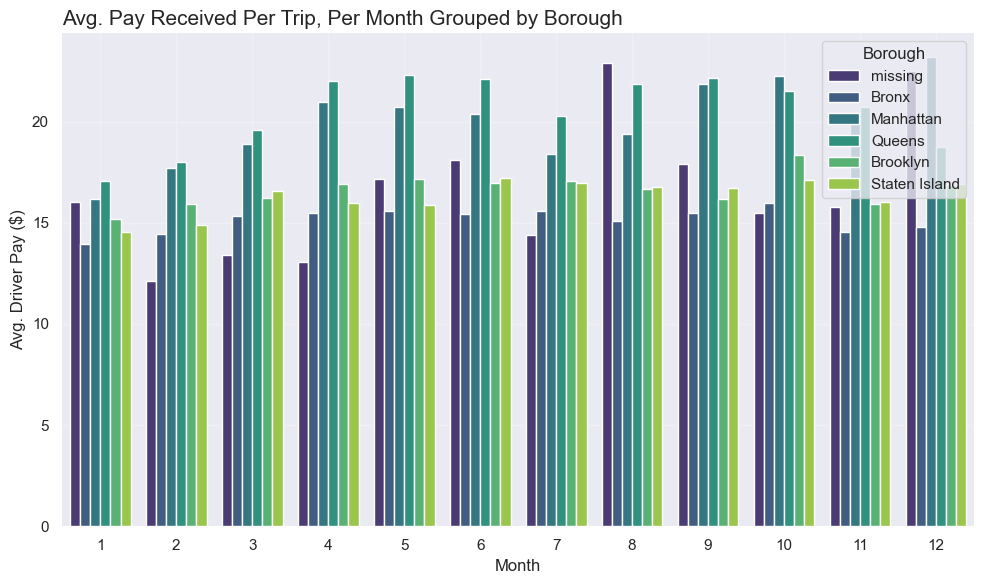

In [107]:
#Converting 'borough' back to strings
average_pay = df.groupby(['month', 'borough'])['driver_pay'].mean().reset_index()
hoods = {0 : 'missing', 1: 'Bronx', 2: 'Manhattan', 3: 'Queens', 
          4: 'Brooklyn', 5: 'Staten Island'}
average_pay['borough'] = average_pay['borough'].map(hoods)
average_pay['month'] = average_pay['month'].astype(str)

#Plotting
plt.figure(figsize=(10,6))
sns.color_palette("viridis", as_cmap=True)
sns.barplot(data=average_pay, x='month', y='driver_pay', hue='borough', palette='viridis')
sns.despine(left=True, bottom=True)

#Labeling
plt.ylabel("Avg. Driver Pay ($)")
plt.xlabel("Month")
plt.grid(True, alpha=.25)
plt.title("Avg. Pay Received Per Trip, Per Month Grouped by Borough", loc='left', fontsize=15)
plt.legend(title='Borough', loc = 'upper right')
plt.tight_layout()
plt.show();

In [108]:
df.head()

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,month,day
req_index,,,,,,,,,,,,,,,,,,
2022-01-04,183.0,20.0,4.148,17.69,4.95,12.13,0.00,1900-01-01 07:32:25,2022-01-04,1900-01-01 07:38:25,2022-01-04,1900-01-01 07:53:23,27.6,0,Pelham Bay,1,1,4
2022-01-04,262.0,238.0,1.630,10.11,0.00,7.68,2.75,1900-01-01 07:15:54,2022-01-04,1900-01-01 07:17:45,2022-01-04,1900-01-01 07:29:10,27.6,0,Yorkville East,2,1,4
2022-01-04,50.0,161.0,1.751,10.05,2.00,7.85,2.75,1900-01-01 07:15:54,2022-01-04,1900-01-01 07:23:33,2022-01-04,1900-01-01 07:32:34,27.6,0,Clinton West,2,1,4
2022-01-04,124.0,124.0,1.633,10.76,0.00,5.47,0.00,1900-01-01 07:15:54,2022-01-04,1900-01-01 07:23:11,2022-01-04,1900-01-01 07:28:24,27.6,0,Howard Beach,3,1,4
2022-01-04,180.0,63.0,6.070,24.41,0.00,16.33,0.00,1900-01-01 07:15:54,2022-01-04,1900-01-01 07:19:39,2022-01-04,1900-01-01 07:38:50,27.6,0,Ozone Park,3,1,4


In [109]:
day = df[['day']]
day.value_counts()

day
4      211488
19     199794
17     188484
29     180458
22     173082
15     165508
24     160596
9      160436
12     160418
2      160354
14     157864
7      143082
25     140498
26     140374
11     140366
27     140328
8      137566
5      127992
21     127770
20     120322
6      120278
13     102968
31     100328
28     100290
23     100266
10     100264
3       81514
18      73000
30      60170
Name: count, dtype: int64

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


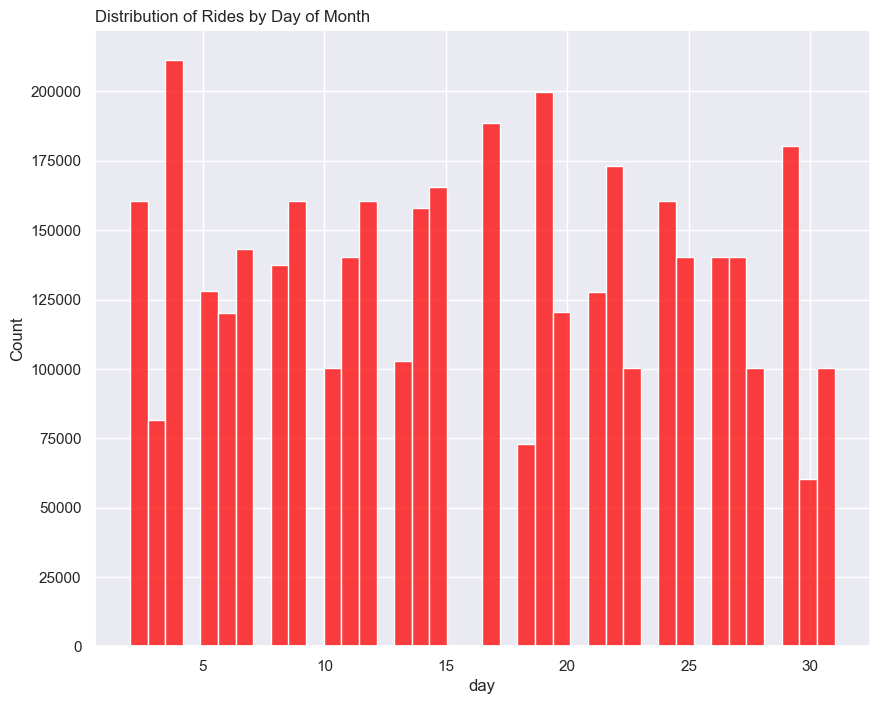

In [110]:
#Plotting distribution by month day
plt.figure(figsize=(10,8))
sns.histplot(df['day'], color='red', bins=40)
plt.title('Distribution of Rides by Day of Month', loc='left');

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/s

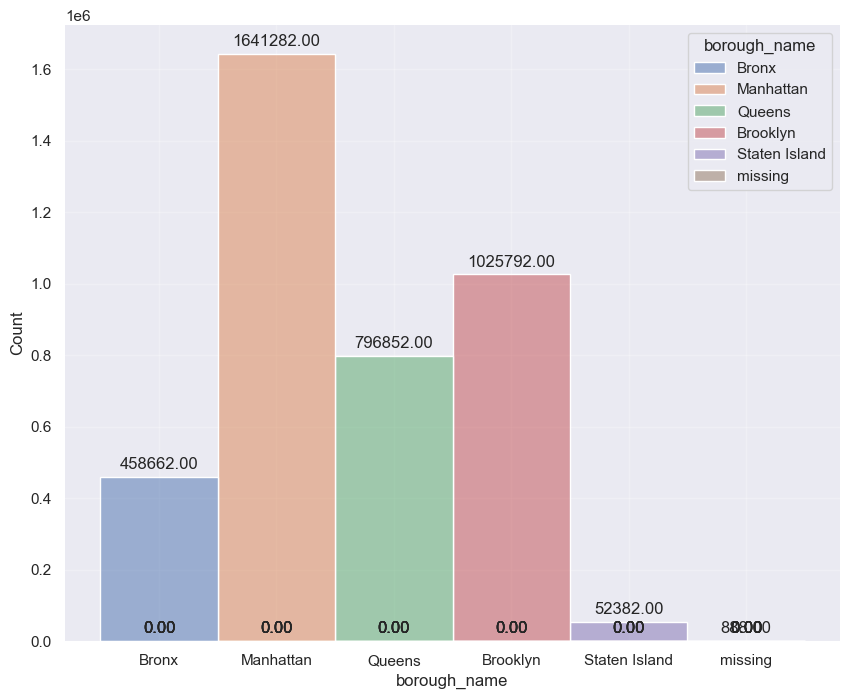

In [111]:
# Creating neighborhood labels
hoods = {0 : 'missing', 1: 'Bronx', 2: 'Manhattan', 3: 'Queens', 
          4: 'Brooklyn', 5: 'Staten Island'}
df['borough_name'] = df['borough'].map(hoods)


#Plotting
plt.figure(figsize=(10,8))
ax = sns.histplot(df, x=df['borough_name'], hue='borough_name', bins=40);
plt.grid(True, alpha=.25)
sns.despine(left=True, bottom=True)


# Adding annotations
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points');

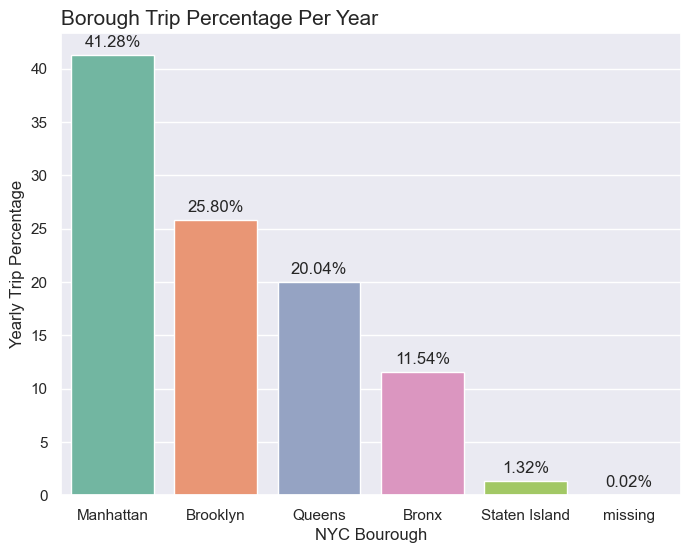

In [112]:
#Creating a small rides percentage per borough dataframe to plot
ride_percent_borough = df['borough_name'].value_counts()/len(df['borough_name'])
ride_percent_borough = pd.DataFrame(ride_percent_borough)


#Plotting
plt.figure(figsize=(8,6))
sns.color_palette("Set2", as_cmap=True)
ax = sns.barplot(x=ride_percent_borough.index, y=ride_percent_borough['count']*100, palette="Set2", estimator=np.mean);
plt.ylabel("Yearly Trip Percentage")
plt.xlabel("NYC Bourough")
plt.title("Borough Trip Percentage Per Year", loc='left', fontsize=15);


# Adding annotations
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points');

In [113]:
#precip = {'missing': 0, 'rain': 1, 'snow': 2, 'rain,snow': 3, 
          # 'rain,freezingrain,snow': 4, 'rain,freezingrain,snow,ice': 5,
          # 'rain,freezingrain': 6, 'freezingrain': 6, 'freezingrain,snow,ice': 5, 'rain,snow,ice': 5}

In [114]:
precip = {0: 'clear', 1: 'rain', 2: 'snow', 3: 'rain,snow', 
          4: 'rain,freezingrain,snow', 5: 'rain,freezingrain,snow,ice',
          6: 'rain,freezingrain', 6: 'freezingrain', 5: 'freezingrain,snow,ice', 5: 'rain,snow,ice'}

df['preciptype'] = df['preciptype'].map(precip)

df

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,month,day,borough_name
req_index,,,,,,,,,,,,,,,,,,,
2022-01-04,183.0,20.0,4.148,17.69,4.95,12.13,0.00,1900-01-01 07:32:25,2022-01-04,1900-01-01 07:38:25,2022-01-04,1900-01-01 07:53:23,27.6,clear,Pelham Bay,1,1,4,Bronx
2022-01-04,262.0,238.0,1.630,10.11,0.00,7.68,2.75,1900-01-01 07:15:54,2022-01-04,1900-01-01 07:17:45,2022-01-04,1900-01-01 07:29:10,27.6,clear,Yorkville East,2,1,4,Manhattan
2022-01-04,50.0,161.0,1.751,10.05,2.00,7.85,2.75,1900-01-01 07:15:54,2022-01-04,1900-01-01 07:23:33,2022-01-04,1900-01-01 07:32:34,27.6,clear,Clinton West,2,1,4,Manhattan
2022-01-04,124.0,124.0,1.633,10.76,0.00,5.47,0.00,1900-01-01 07:15:54,2022-01-04,1900-01-01 07:23:11,2022-01-04,1900-01-01 07:28:24,27.6,clear,Howard Beach,3,1,4,Queens
2022-01-04,180.0,63.0,6.070,24.41,0.00,16.33,0.00,1900-01-01 07:15:54,2022-01-04,1900-01-01 07:19:39,2022-01-04,1900-01-01 07:38:50,27.6,clear,Ozone Park,3,1,4,Queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,129.0,228.0,14.602,35.75,0.00,29.44,0.00,1900-01-01 04:39:08,2022-12-31,1900-01-01 04:45:18,2022-12-31,1900-01-01 05:08:43,49.8,rain,Jackson Heights,3,12,31,Queens
2022-12-31,234.0,71.0,12.930,54.73,0.00,33.48,2.75,1900-01-01 04:39:09,2022-12-31,1900-01-01 04:45:21,2022-12-31,1900-01-01 05:17:02,49.8,rain,Union Sq,2,12,31,Manhattan
2022-12-31,131.0,265.0,21.430,58.15,0.00,44.73,0.00,1900-01-01 04:39:09,2022-12-31,1900-01-01 04:47:52,2022-12-31,1900-01-01 05:14:02,49.8,rain,Jamaica Estates,3,12,31,Queens


/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/s

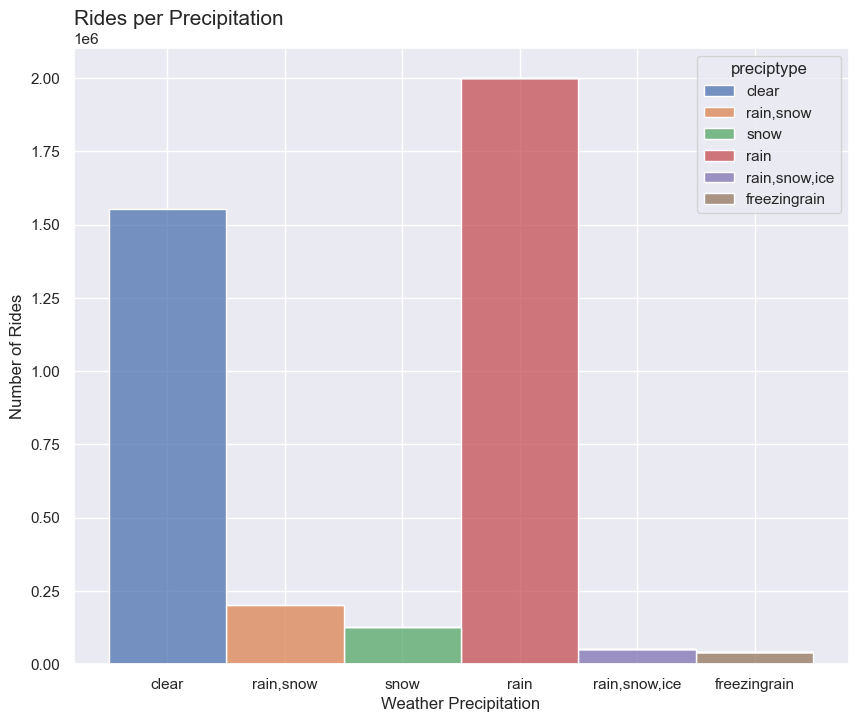

In [115]:
plt.figure(figsize=(10,8))

sns.histplot(data=df, x='preciptype', hue='preciptype', bins=40, multiple='stack')
plt.title("Rides per Precipitation", loc="left", fontsize=15)
plt.xlabel("Weather Precipitation")
plt.ylabel("Number of Rides");


#Adding annotations
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points');

In [116]:
df['req_time'] = pd.to_datetime(df['req_time'], format= 'mixed')
df['req_time'] = df['req_time'].dt.floor('min')
df['req_time']

req_index
2022-01-04   1900-01-01 07:32:00
2022-01-04   1900-01-01 07:15:00
2022-01-04   1900-01-01 07:15:00
2022-01-04   1900-01-01 07:15:00
2022-01-04   1900-01-01 07:15:00
                     ...        
2022-12-31   1900-01-01 04:39:00
2022-12-31   1900-01-01 04:39:00
2022-12-31   1900-01-01 04:39:00
2022-12-31   1900-01-01 04:39:00
2022-12-31   1900-01-01 05:03:00
Name: req_time, Length: 3975858, dtype: datetime64[ns]

In [117]:
df['req_time'] = df['req_time'].dt.strftime('%H:%M:%S')
df.head(3)

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,month,day,borough_name
req_index,,,,,,,,,,,,,,,,,,,
2022-01-04,183.0,20.0,4.148,17.69,4.95,12.13,0.00,07:32:00,2022-01-04,1900-01-01 07:38:25,2022-01-04,1900-01-01 07:53:23,27.6,clear,Pelham Bay,1,1,4,Bronx
2022-01-04,262.0,238.0,1.630,10.11,0.00,7.68,2.75,07:15:00,2022-01-04,1900-01-01 07:17:45,2022-01-04,1900-01-01 07:29:10,27.6,clear,Yorkville East,2,1,4,Manhattan
2022-01-04,50.0,161.0,1.751,10.05,2.00,7.85,2.75,07:15:00,2022-01-04,1900-01-01 07:23:33,2022-01-04,1900-01-01 07:32:34,27.6,clear,Clinton West,2,1,4,Manhattan


In [118]:
df['req_hour'] = pd.to_datetime(df['req_time'])
df['req_hour'] = df['req_hour'].dt.hour
df.head(3)

/var/folders/1m/70vlnx9n73v__kwg38x_j79h0000gn/T/ipykernel_8849/4194631276.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['req_hour'] = pd.to_datetime(df['req_time'])


,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,month,day,borough_name,req_hour
req_index,,,,,,,,,,,,,,,,,,,,
2022-01-04,183.0,20.0,4.148,17.69,4.95,12.13,0.00,07:32:00,2022-01-04,1900-01-01 07:38:25,2022-01-04,1900-01-01 07:53:23,27.6,clear,Pelham Bay,1,1,4,Bronx,7
2022-01-04,262.0,238.0,1.630,10.11,0.00,7.68,2.75,07:15:00,2022-01-04,1900-01-01 07:17:45,2022-01-04,1900-01-01 07:29:10,27.6,clear,Yorkville East,2,1,4,Manhattan,7
2022-01-04,50.0,161.0,1.751,10.05,2.00,7.85,2.75,07:15:00,2022-01-04,1900-01-01 07:23:33,2022-01-04,1900-01-01 07:32:34,27.6,clear,Clinton West,2,1,4,Manhattan,7


/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='req_index', ylabel='Count'>

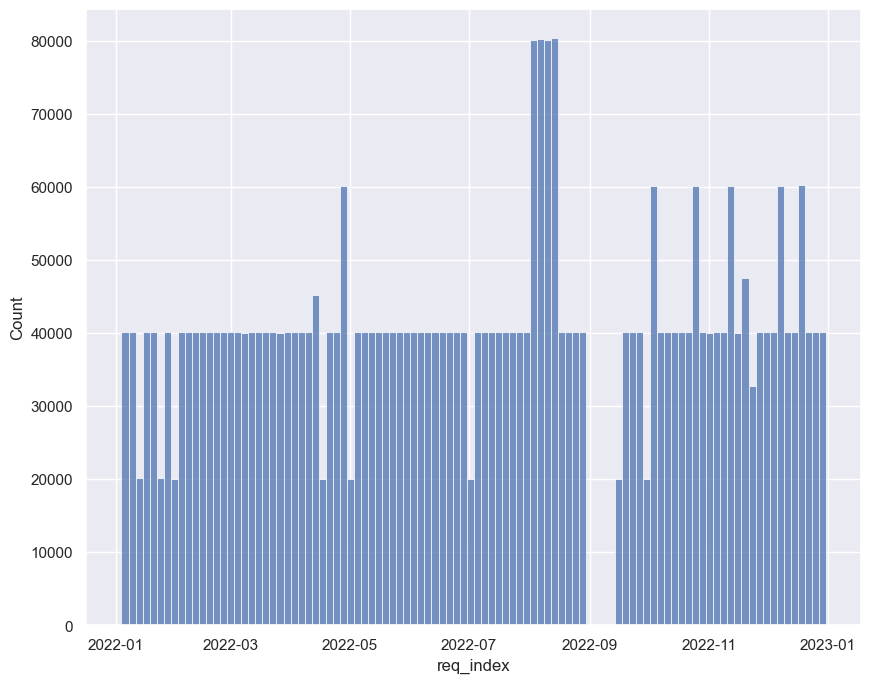

In [258]:
plt.figure(figsize=(10,8))

sns.histplot(x=df[', bins=100)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='req_hour', ylabel='Count'>

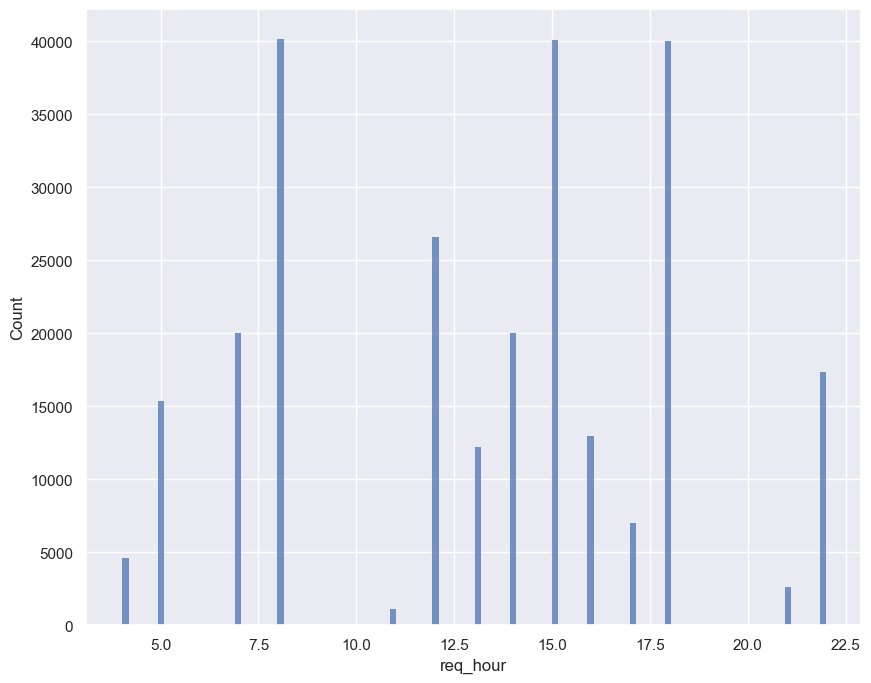

In [119]:
plt.figure(figsize=(10,8))

sns.histplot(x=df['req_hour'].loc['2022-01'], bins=100)

/var/folders/1m/70vlnx9n73v__kwg38x_j79h0000gn/T/ipykernel_8849/2327959512.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['req_hour'].loc['2022-04'], palette='red', bins=30, kde=True)
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='req_hour', ylabel='Count'>

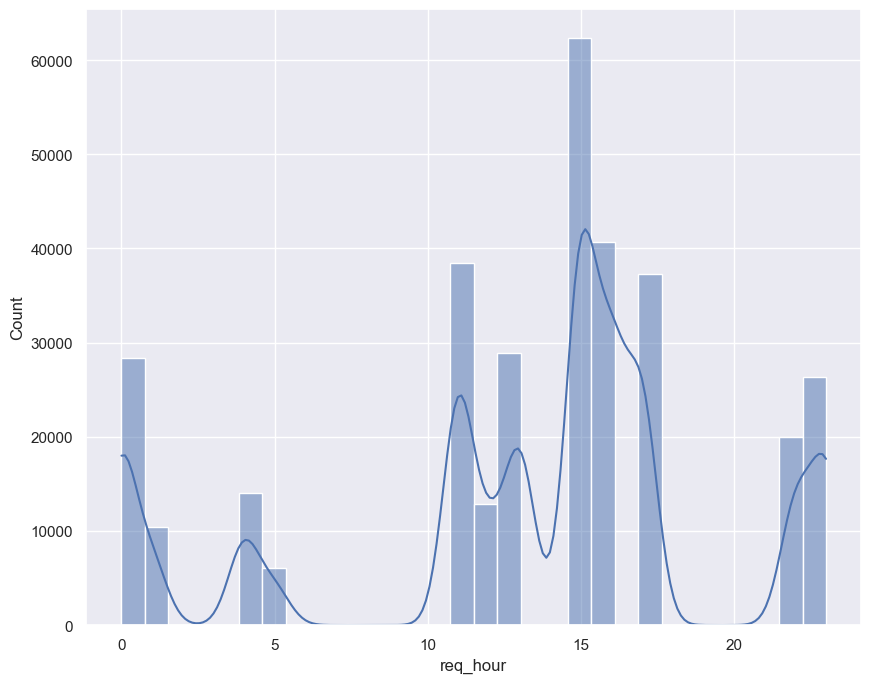

In [120]:
plt.figure(figsize=(10,8))

#sns.color_palette("BuGn", as_cmap=True)
sns.histplot(df['req_hour'].loc['2022-04'], palette='red', bins=30, kde=True)

In [121]:
round(df.describe())

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,temp,borough,month,day,req_hour
count,3975858.0,3975858.0,3975858.0,3975858.0,3975858.0,3975858.0,3975858.0,3975858.0,3975858.0,3975858.0,3975858.0,3975858.0
mean,139.0,143.0,5.0,24.0,1.0,19.0,1.0,57.0,3.0,7.0,16.0,13.0
std,75.0,78.0,6.0,20.0,3.0,15.0,1.0,18.0,1.0,3.0,9.0,6.0
min,2.0,1.0,0.0,-105.0,0.0,-67.0,0.0,17.0,0.0,1.0,2.0,0.0
25%,75.0,76.0,2.0,11.0,0.0,9.0,0.0,43.0,2.0,4.0,9.0,9.0
50%,140.0,141.0,3.0,18.0,0.0,14.0,0.0,58.0,2.0,7.0,17.0,14.0
75%,211.0,217.0,6.0,29.0,0.0,23.0,3.0,73.0,4.0,10.0,24.0,19.0
max,265.0,265.0,464.0,1449.0,168.0,1089.0,6.0,87.0,5.0,12.0,31.0,23.0


In [180]:
#Getting rid of the date on the pickup and dropoff time to figure out trip duration

#Pickup time
df['pickup_time'] = pd.to_datetime(df['pickup_time'], format= 'mixed')
df['pickup_time'] = df['pickup_time'].dt.floor('min')


#Dropoff time
df['dropoff_time'] = pd.to_datetime(df['dropoff_time'], format= 'mixed')
df['dropoff_time'] = df['dropoff_time'].dt.floor('min')

#Creating a new column of the trip duration
df['trip_duration'] = df['dropoff_time'] - df['pickup_time']

#Converting trip duration timedelta type to seconds
df['trip_duration'] = df['trip_duration'].dt.seconds

#Making pickup and dropoff just the time
df['pickup_time'] = df['pickup_time'].dt.time
df['dropoff_time'] = df['dropoff_time'].dt.time

#Calculating the average trip time
avg_trip_duration = df['trip_duration'].mean()/60
avg_trip_duration

19.503148251270545

In [184]:
df['tips_driver_pay'] = df['tips'] + df['driver_pay']
df['req_time'] = pd.to_datetime(df['req_time']).dt.time
df.head(3)

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,tips_driver_pay,trip_duration
req_index,,,,,,,,,,,,,,,,,,
2022-01-04,183.0,20.0,4.148,17.69,4.95,12.13,0.00,07:32:25,2022-01-04,07:38:00,2022-01-04,07:53:00,27.6,0,Pelham Bay,1,17.08,900
2022-01-04,262.0,238.0,1.630,10.11,0.00,7.68,2.75,07:15:54,2022-01-04,07:17:00,2022-01-04,07:29:00,27.6,0,Yorkville East,2,7.68,720
2022-01-04,50.0,161.0,1.751,10.05,2.00,7.85,2.75,07:15:54,2022-01-04,07:23:00,2022-01-04,07:32:00,27.6,0,Clinton West,2,9.85,540


/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


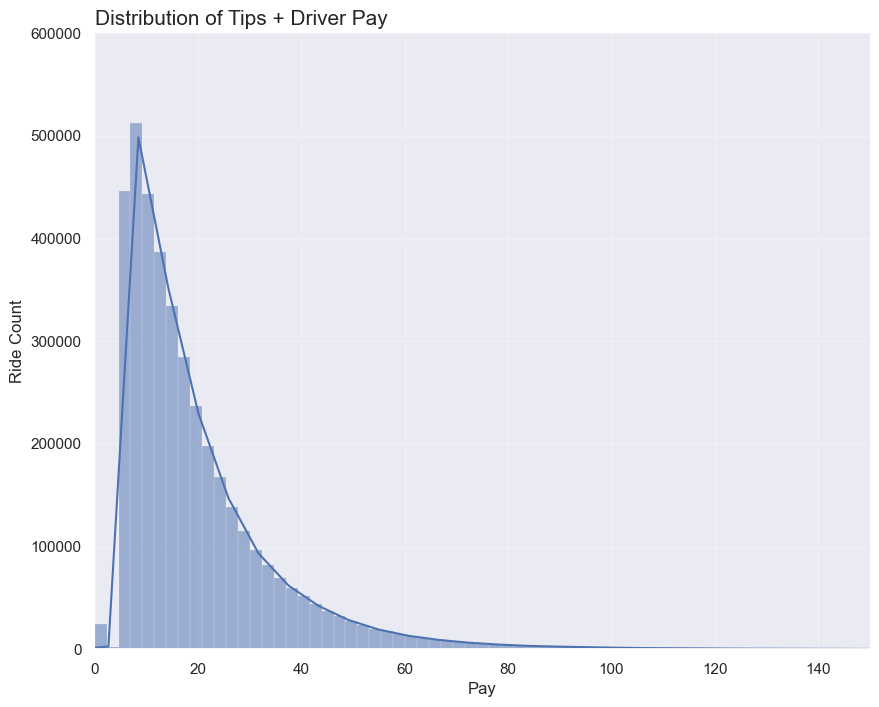

In [218]:
#Looking at best tips + pay
plt.figure(figsize=(10, 8))
sns.histplot(df['tips_driver_pay'], bins=500, kde=True)
plt.xlim(0, 150)
plt.ylim(0, 600000)
plt.title("Distribution of Tips + Driver Pay", loc='left', fontsize=15)
plt.xlabel("Pay")
plt.ylabel("Ride Count")
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


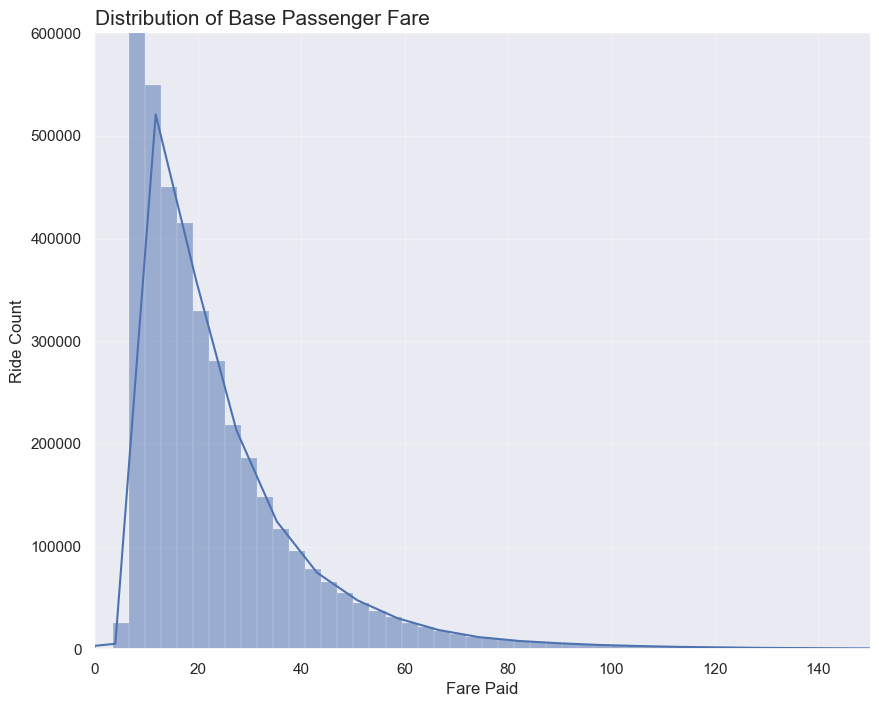

In [124]:
#Looking at the distribution of base passenger fair

plt.figure(figsize=(10, 8))
sns.histplot(df['base_passenger_fare'], bins=500, kde=True)
plt.xlim(0, 150)
plt.ylim(0, 600000)
plt.title("Distribution of Base Passenger Fare", loc='left', fontsize=15)
plt.xlabel("Fare Paid")
plt.ylabel("Ride Count")
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


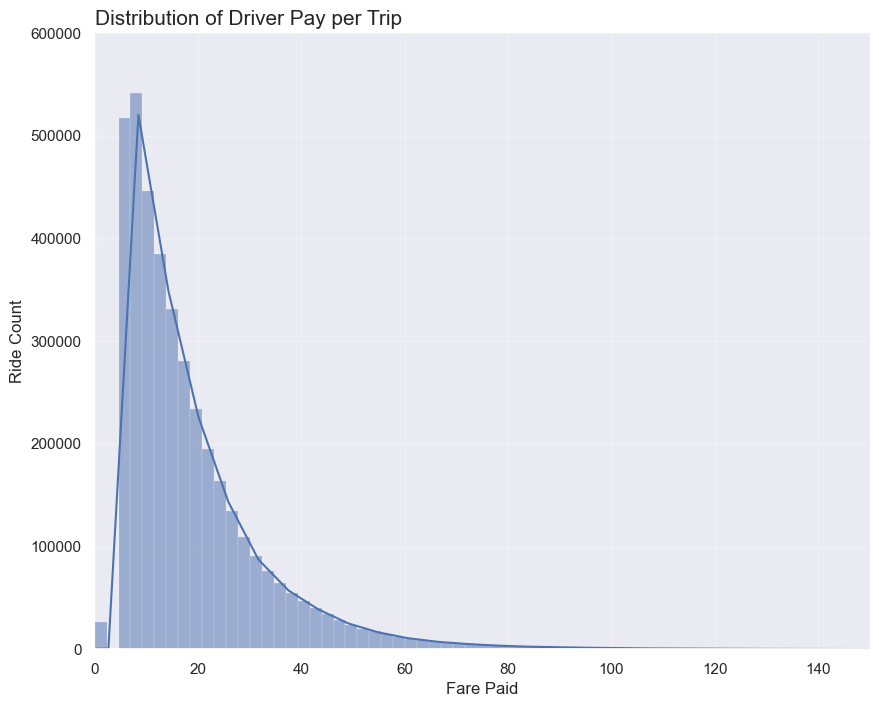

In [125]:
plt.figure(figsize=(10, 8))
sns.histplot(df['driver_pay'], bins=500, kde=True)
plt.xlim(0,150)
plt.ylim(0, 600000)
plt.title("Distribution of Driver Pay per Trip", loc='left', fontsize=15)
plt.xlabel("Fare Paid")
plt.ylabel("Ride Count")
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)

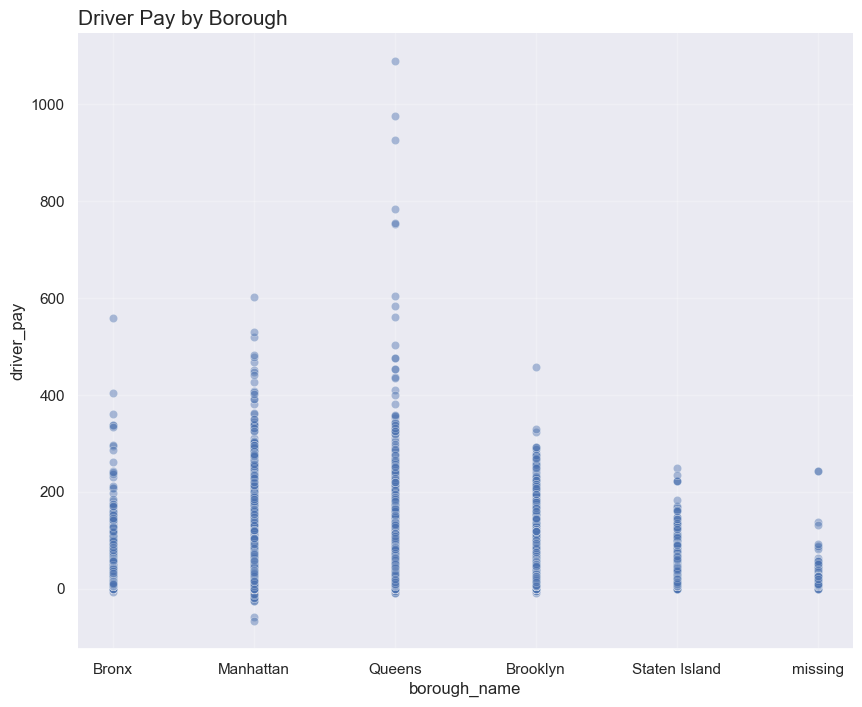

In [126]:
plt.figure(figsize=(10, 8))
sns.color_palette("Paired")
sns.scatterplot(x = df['borough_name'], y = df['driver_pay'], alpha=.25)
plt.title("Driver Pay by Borough", loc='left', fontsize=15)
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)

In [156]:
df['pickup_hour'] = pd.to_datetime(df['pickup_time'], format='mixed').dt.hour
df['pickup_hour'] = df['pickup_time'].dt.hour
#df.pickup_time.value_counts()
#df.pickup_time.isna().sum()
#df['pickup_time'] = df['pickup_time'].dt.strftime("%H:%M:%S")

TypeError: <class 'datetime.time'> is not convertible to datetime, at position 0

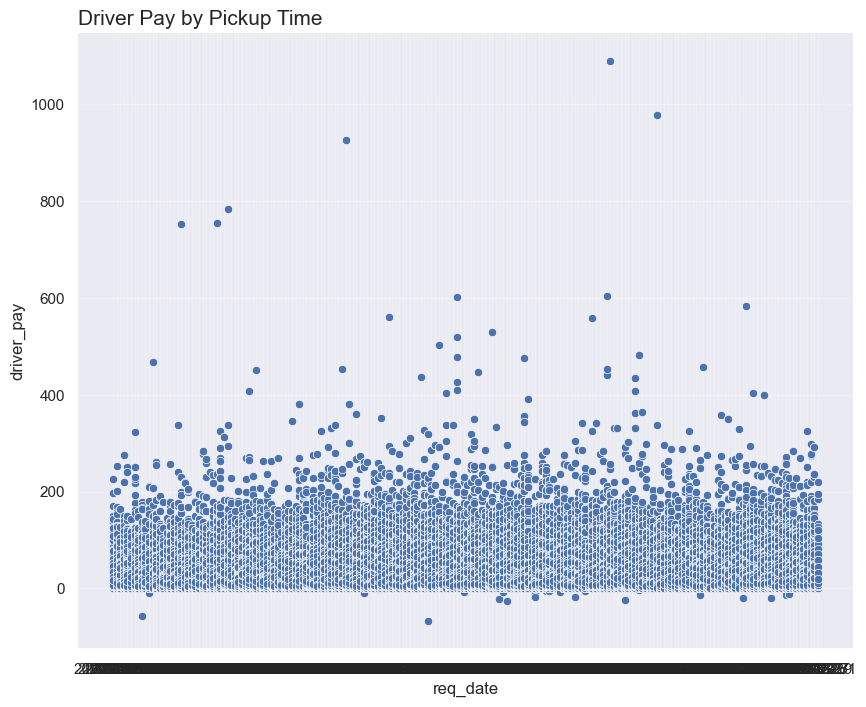

In [128]:
plt.figure(figsize=(10, 8))
sns.color_palette("Paired")
sns.scatterplot(x=df['req_date'], y=df['driver_pay'])
plt.title("Driver Pay by Pickup Time", loc='left', fontsize=15)
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)

In [129]:
time_df = df[['day', 'month', 'req_hour', 'driver_pay', 'preciptype', 'temp', 'PULocationID', 'borough_name', 'borough', 'tips']]
time_df.corr(numeric_only=True)

,day,month,req_hour,driver_pay,temp,PULocationID,borough,tips
day,1.000000,-0.005869,-0.118945,0.004361,-0.037701,-0.004943,0.006738,0.001452
month,-0.005869,1.000000,-0.000971,0.051133,0.244406,0.003251,0.000044,0.031384
req_hour,-0.118945,-0.000971,1.000000,0.008419,0.028279,0.020192,-0.015377,0.014065
driver_pay,0.004361,0.051133,0.008419,1.000000,0.034907,0.027121,-0.021009,0.336665
temp,-0.037701,0.244406,0.028279,0.034907,1.000000,0.000091,-0.002302,0.008321
PULocationID,-0.004943,0.003251,0.020192,0.027121,0.000091,1.000000,-0.252457,0.029071
borough,0.006738,0.000044,-0.015377,-0.021009,-0.002302,-0.252457,1.000000,-0.011087
tips,0.001452,0.031384,0.014065,0.336665,0.008321,0.029071,-0.011087,1.000000


/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='month', ylabel='tips'>

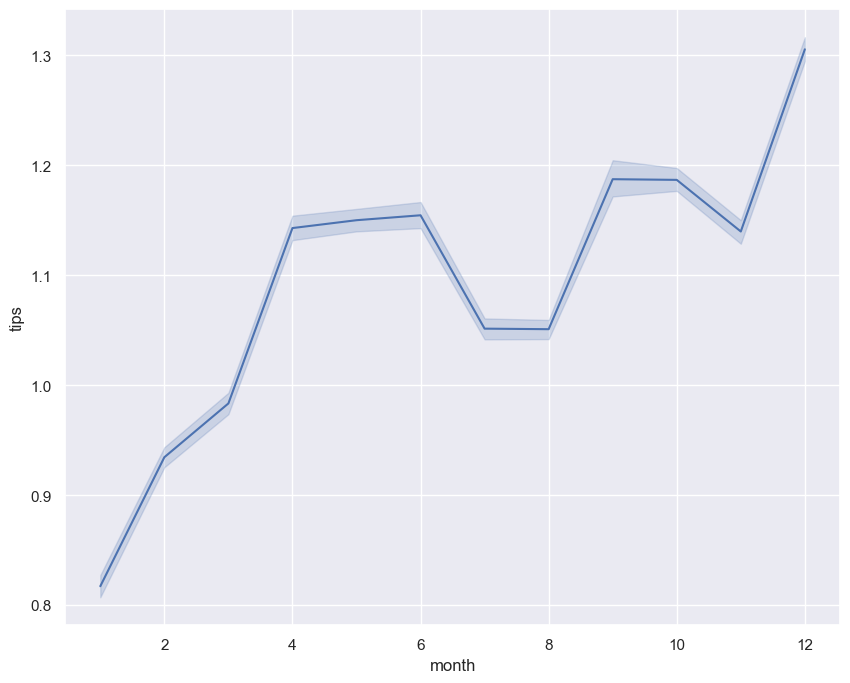

In [175]:
plt.figure(figsize=(10, 8))
sns.lineplot(x=time_df['month'], y=time_df['driver_pay'])

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


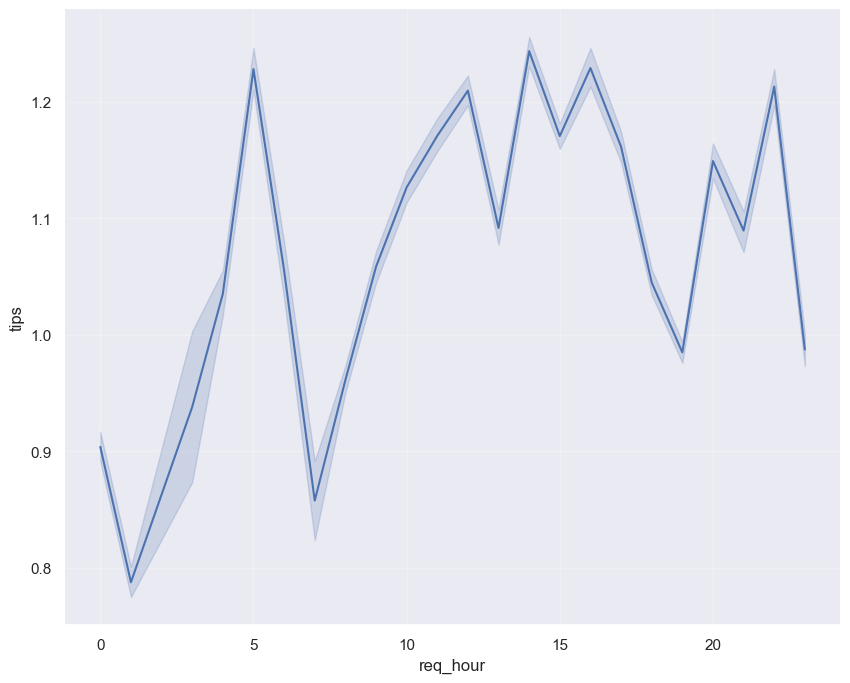

In [130]:
plt.figure(figsize=(10, 8))
sns.lineplot(x=time_df['req_hour'], y=time_df['tips'])
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.0, 1.0, 'Tips by Month')

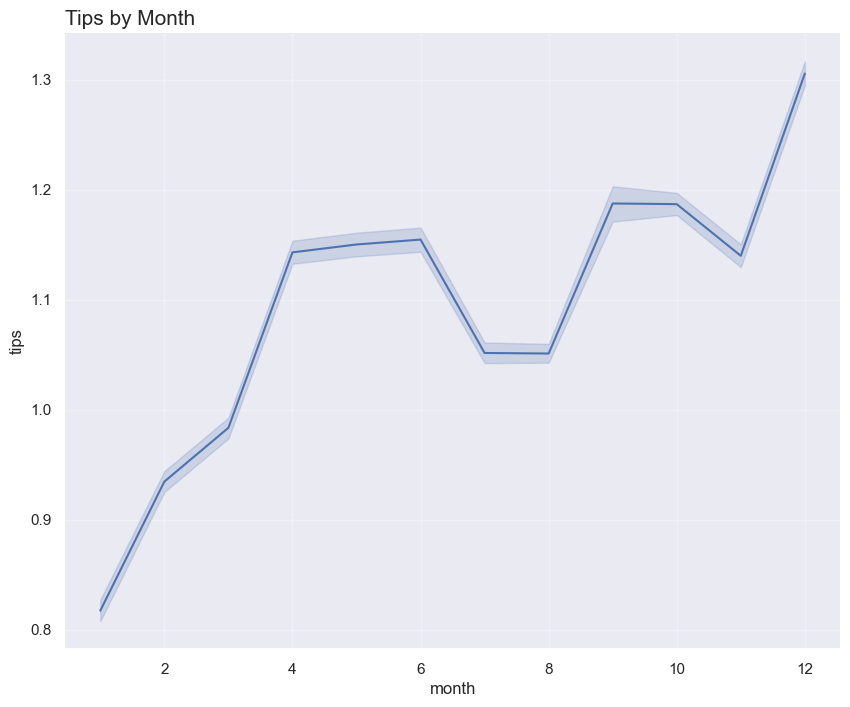

In [131]:
plt.figure(figsize=(10, 8))
sns.lineplot(x=time_df['month'], y=time_df['tips'])
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)
plt.title("Tips by Month", loc='left', fontsize=15)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

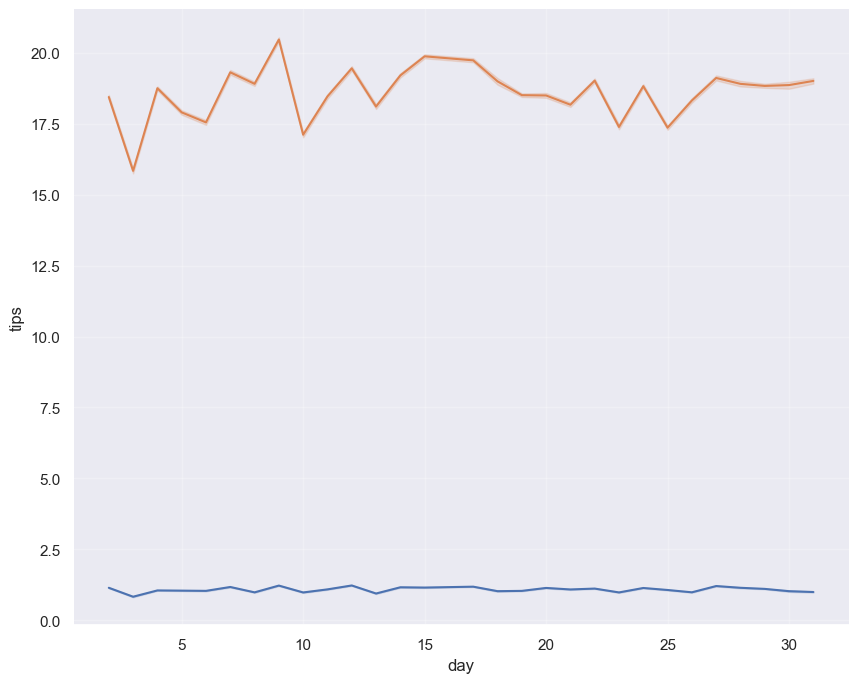

In [132]:
plt.figure(figsize=(10, 8))
sns.lineplot(x=time_df['day'], y=time_df['tips'])
sns.lineplot(x=time_df['day'], y=time_df['driver_pay'])
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

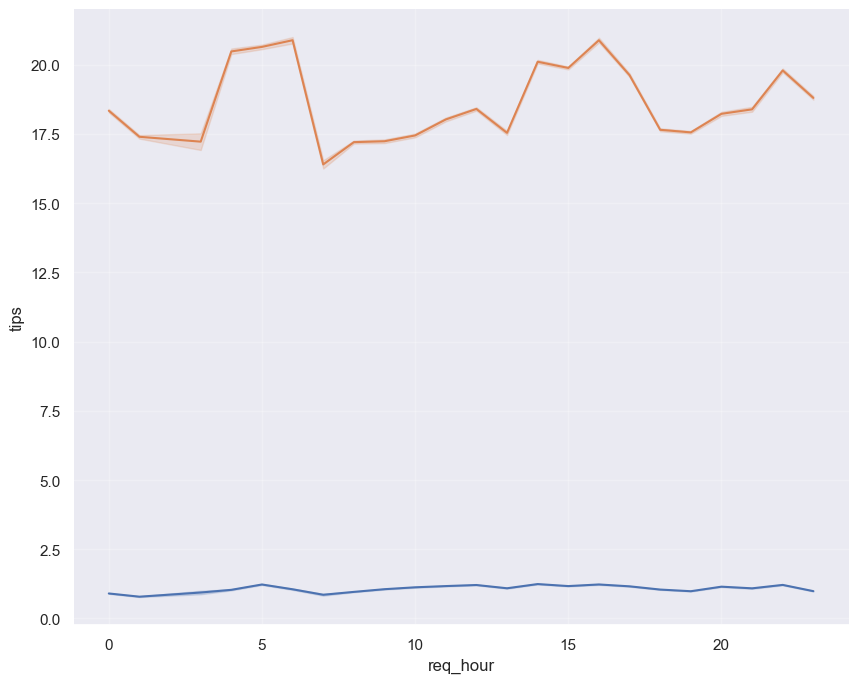

In [217]:
plt.figure(figsize=(10, 8))
sns.lineplot(x=time_df['req_hour'], y=time_df['tips'])
sns.lineplot(x=time_df['req_hour'], y=time_df['driver_pay'])
plt.grid(True, alpha=.25)
sns.despine(top=True, left=True)

In [134]:
df['trip_duration'] = df['trip_duration']/60
df

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,month,day,borough_name,req_hour,trip_duration
req_index,,,,,,,,,,,,,,,,,,,,,
2022-01-04,183.0,20.0,4.148,17.69,4.95,12.13,0.00,07:32:00,2022-01-04,07:38:00,2022-01-04,07:53:00,27.6,clear,Pelham Bay,1,1,4,Bronx,7,15.0
2022-01-04,262.0,238.0,1.630,10.11,0.00,7.68,2.75,07:15:00,2022-01-04,07:17:00,2022-01-04,07:29:00,27.6,clear,Yorkville East,2,1,4,Manhattan,7,12.0
2022-01-04,50.0,161.0,1.751,10.05,2.00,7.85,2.75,07:15:00,2022-01-04,07:23:00,2022-01-04,07:32:00,27.6,clear,Clinton West,2,1,4,Manhattan,7,9.0
2022-01-04,124.0,124.0,1.633,10.76,0.00,5.47,0.00,07:15:00,2022-01-04,07:23:00,2022-01-04,07:28:00,27.6,clear,Howard Beach,3,1,4,Queens,7,5.0
2022-01-04,180.0,63.0,6.070,24.41,0.00,16.33,0.00,07:15:00,2022-01-04,07:19:00,2022-01-04,07:38:00,27.6,clear,Ozone Park,3,1,4,Queens,7,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,129.0,228.0,14.602,35.75,0.00,29.44,0.00,04:39:00,2022-12-31,04:45:00,2022-12-31,05:08:00,49.8,rain,Jackson Heights,3,12,31,Queens,4,23.0
2022-12-31,234.0,71.0,12.930,54.73,0.00,33.48,2.75,04:39:00,2022-12-31,04:45:00,2022-12-31,05:17:00,49.8,rain,Union Sq,2,12,31,Manhattan,4,32.0
2022-12-31,131.0,265.0,21.430,58.15,0.00,44.73,0.00,04:39:00,2022-12-31,04:47:00,2022-12-31,05:14:00,49.8,rain,Jamaica Estates,3,12,31,Queens,4,27.0


In [157]:
#df.to_csv('../data/nyc_taxi_records.csv')

In [136]:
#Bronx: Calculating the maximum driver pay per hour and where it is located
bronx = df[df['borough_name'] == 'Bronx']
bronx_hour = bronx[['driver_pay', 'zone', 'req_hour']]
bronx_avg_driver_pay = bronx_hour.groupby(['zone', 'req_hour'])['driver_pay'].mean().reset_index()
bronx_max_avg_pay_per_hour = bronx_avg_driver_pay.groupby('req_hour')['driver_pay'].max().reset_index()
bronx_best_pay_hour = pd.merge(bronx_max_avg_pay_per_hour, bronx_avg_driver_pay, on=['req_hour', 'driver_pay'], how='inner')
bronx_best_pay_hour

,req_hour,driver_pay,zone
0,0,21.099583,City Island
1,1,23.544375,Bronx Park
2,3,35.255000,Country Club
3,4,37.013750,City Island
4,5,23.501875,City Island
5,6,34.643333,City Island
6,7,18.570588,Spuyten Duyvil/Kingsbridge
7,8,19.118000,City Island
8,9,22.722308,City Island
9,10,21.352222,City Island


In [137]:
#Manhattan: Calculating the maximum driver pay per hour and where it is located, Bronx
man = df[df['borough_name'] == 'Manhattan']
man_hour = man[['driver_pay', 'zone', 'req_hour']]
man_avg_driver_pay = man_hour.groupby(['zone', 'req_hour'])['driver_pay'].mean().reset_index()
man_max_avg_pay_per_hour = man_avg_driver_pay.groupby('req_hour')['driver_pay'].max().reset_index()
man_best_pay_hour = pd.merge(man_max_avg_pay_per_hour, man_avg_driver_pay, on=['req_hour', 'driver_pay'], how='inner')
man_best_pay_hour

,req_hour,driver_pay,zone
0,0,22.677117,Seaport
1,1,30.170000,Randalls Island
2,3,31.545000,Lincoln Square West
3,4,33.473980,Battery Park City
4,5,33.983901,Battery Park City
5,6,30.780000,Randalls Island
6,7,28.273000,Financial District South
7,8,23.606212,Roosevelt Island
8,9,28.113333,Battery Park
9,10,23.464769,Financial District South


In [138]:
#Brooklyn: Calculating the maximum driver pay per hour and where it is located
brooklyn = df[df['borough_name'] == 'Brooklyn']
brooklyn_hour = brooklyn[['driver_pay', 'zone', 'req_hour']]
brooklyn_avg_driver_pay = brooklyn_hour.groupby(['zone', 'req_hour'])['driver_pay'].mean().reset_index()
brooklyn_max_avg_pay_per_hour = brooklyn_avg_driver_pay.groupby('req_hour')['driver_pay'].max().reset_index()
brooklyn_best_pay_hour = pd.merge(brooklyn_max_avg_pay_per_hour, brooklyn_avg_driver_pay, on=['req_hour', 'driver_pay'], how='inner')
brooklyn_best_pay_hour

,req_hour,driver_pay,zone
0,0,20.835576,Coney Island
1,1,36.705000,Marine Park/Floyd Bennett Field
2,3,42.895000,DUMBO/Vinegar Hill
3,4,37.620000,Marine Park/Floyd Bennett Field
4,5,33.003571,Cobble Hill
5,6,35.889388,Brooklyn Heights
6,7,26.716667,Columbia Street
7,8,26.109672,Columbia Street
8,9,26.798571,Marine Park/Floyd Bennett Field
9,10,20.771695,Red Hook


In [139]:
#Queens: Calculating the maximum driver pay per hour and where it is located
queens = df[df['borough_name'] == 'Queens']
queens_hour = queens[['driver_pay', 'zone', 'req_hour']]
queens_avg_driver_pay = queens_hour.groupby(['zone', 'req_hour'])['driver_pay'].mean().reset_index()
queens_max_avg_pay_per_hour = queens_avg_driver_pay.groupby('req_hour')['driver_pay'].max().reset_index()
queens_best_pay_hour = pd.merge(queens_max_avg_pay_per_hour, queens_avg_driver_pay, on=['req_hour', 'driver_pay'], how='inner')
queens_best_pay_hour

,req_hour,driver_pay,zone
0,0,45.039181,JFK Airport
1,1,40.712207,JFK Airport
2,3,32.960000,Douglaston
3,4,47.432353,Bellerose
4,5,38.775115,JFK Airport
5,6,49.464545,Rockaway Park
6,7,46.097626,JFK Airport
7,8,43.745590,JFK Airport
8,9,43.525296,JFK Airport
9,10,43.787676,JFK Airport


In [140]:
#Staten Island Calculating the maximum driver pay per hour and where it is located
si = df[df['borough_name'] == 'Staten Island']
si_hour = si[['driver_pay', 'zone', 'req_hour']]
si_avg_driver_pay = si_hour.groupby(['zone', 'req_hour'])['driver_pay'].mean().reset_index()
si_max_avg_pay_per_hour = si_avg_driver_pay.groupby('req_hour')['driver_pay'].max().reset_index()
si_best_pay_hour = pd.merge(si_max_avg_pay_per_hour, si_avg_driver_pay, on=['req_hour', 'driver_pay'], how='inner')
si_best_pay_hour

,req_hour,driver_pay,zone
0,0,30.202963,Charleston/Tottenville
1,1,29.682000,Oakwood
2,3,46.270000,Arden Heights
3,4,28.638824,South Beach/Dongan Hills
4,5,30.625714,Eltingville/Annadale/Prince's Bay
5,6,41.290000,Freshkills Park
6,7,23.334000,Port Richmond
7,8,22.325526,Arden Heights
8,9,21.828571,Rossville/Woodrow
9,10,34.174444,Rossville/Woodrow


In [141]:
best_pay_hour = pd.merge(si_best_pay_hour, queens_best_pay_hour, on=['req_hour'], how='inner')
best_pay_hour = pd.merge(best_pay_hour, brooklyn_best_pay_hour, on=['req_hour'], how='inner')
best_pay_hour = best_pay_hour.rename(columns={'driver_pay_x': 'staten_driver_pay', 'zone_x': 'staten_island', 
                              'driver_pay_y': 'queens_driver_pay', 'zone_y': 'queens', 'driver_pay':'brooklyn_driver_pay',
                                              'zone': 'brooklyn'})
best_pay_hour = pd.merge(best_pay_hour, man_best_pay_hour, on=['req_hour'], how='inner')
best_pay_hour = best_pay_hour.rename(columns={'driver_pay':'manhattan_driver_pay',
                                              'zone': 'manhattan'})
best_pay_hour = pd.merge(best_pay_hour, bronx_best_pay_hour, on=['req_hour'], how='inner')
best_pay_hour = best_pay_hour.rename(columns={'driver_pay':'bronx_driver_pay',
                                              'zone': 'bronx'})
best_pay_hour.to_csv('../data/best_pay_on_avg.csv')

# Plotting Maps

In [142]:
taxi_zone_map = gpd.read_file('../data/geo_export_24531a71-d96c-47ba-bd35-662b9b12193b.shp')

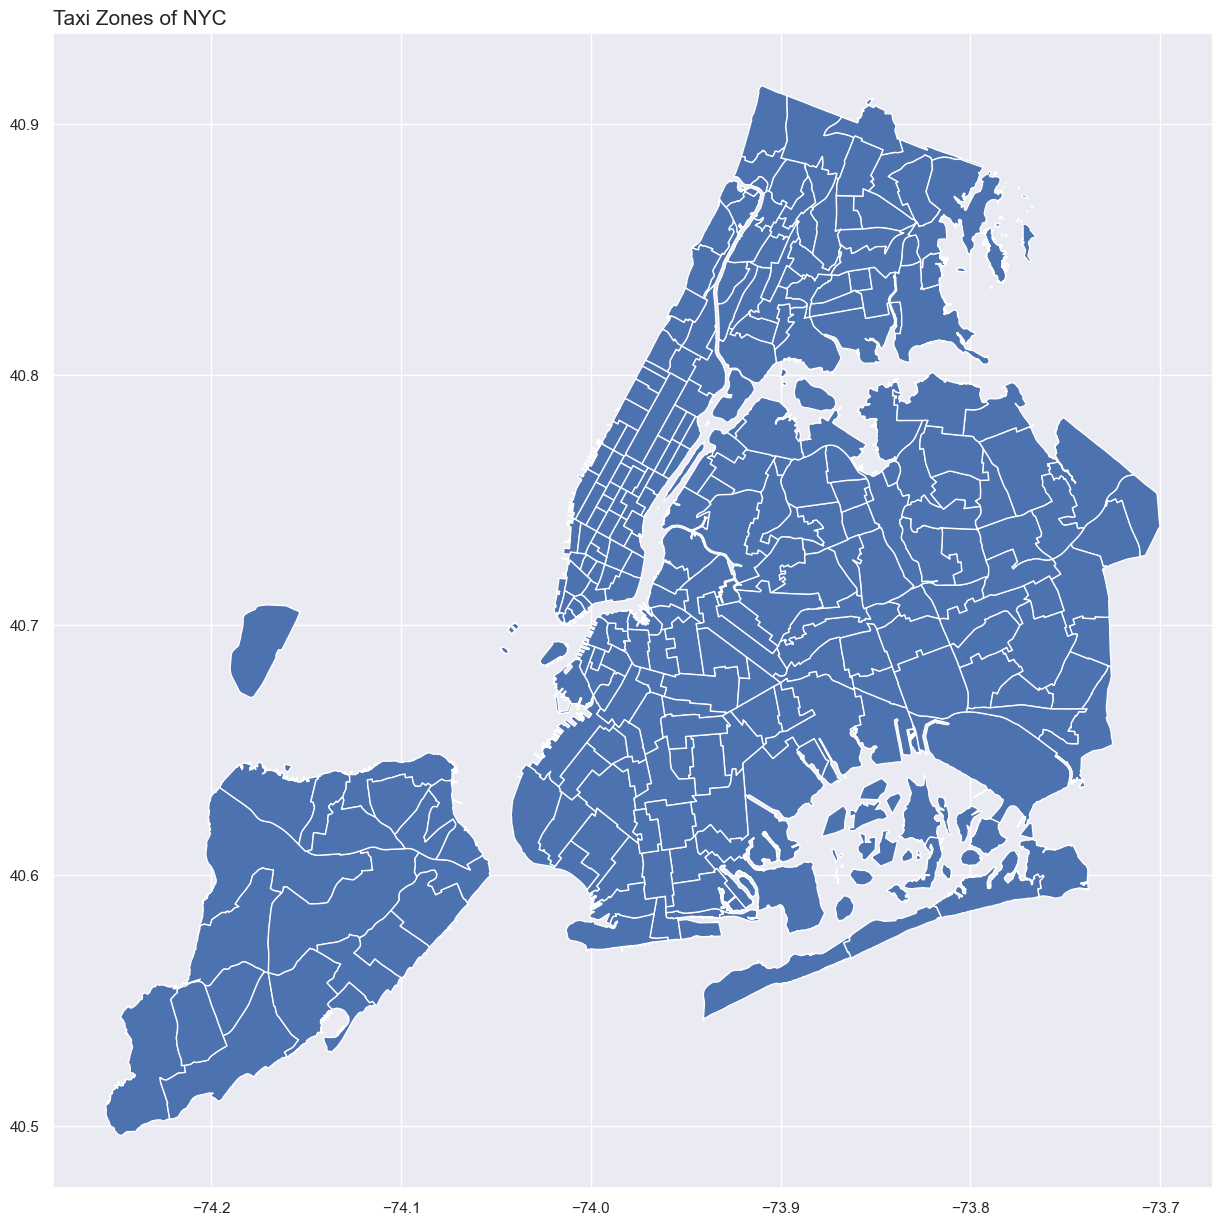

In [143]:
fig, ax = plt.subplots(figsize=(15,15))
taxi_zone_map.plot(ax=ax)
plt.title("Taxi Zones of NYC", loc='left', fontsize=15);

In [144]:
# latlong = pd.read_csv('../data/NHoodNameCentroids.csv')
# crs = {'init':'epsg:4326'}
# latlong.head()

In [145]:
#latlong = latlong.drop(columns=(['OBJECTID', 'Stacked', 'AnnoLine1', 'AnnoLine2', 'AnnoLine3', 'AnnoAngle']))

In [146]:
# latlong['the_geom'] = latlong['the_geom'].str.replace('POINT (', '')
# latlong['the_geom'] = latlong['the_geom'].str.replace(')', '')
# latlong

In [147]:
#latlong[['Longitude', 'Latitude']] = latlong['the_geom'].str.split(' ', expand=True)

In [148]:
# latlong = latlong.rename(columns={'Name': 'zone'})
# latlong

In [149]:
# geometry = [Point(xy) for xy in zip(latlong['Longitude'], latlong['Latitude'])]
# geometry[:3]

In [150]:
# geo_df = gpd.GeoDataFrame(latlong, #specify our data
#                           crs=crs, #specify our coordinate reference system
#                           geometry=geometry) #specify the geometry list we created
# geo_df.head()

In [158]:
taxi_zones = pd.read_csv('../data/taxi_zones.csv')

In [159]:
taxi_zones

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island
...,...,...,...,...,...,...,...
258,256,0.067915,MULTIPOLYGON (((-73.95834207500002 40.71330630...,0.000169,Williamsburg (South Side),256,Brooklyn
259,259,0.126750,MULTIPOLYGON (((-73.85107116191898 40.91037152...,0.000395,Woodlawn/Wakefield,259,Bronx
260,260,0.133514,MULTIPOLYGON (((-73.90175373399988 40.76077547...,0.000422,Woodside,260,Queens
261,261,0.027120,MULTIPOLYGON (((-74.01332610899988 40.70503078...,0.000034,World Trade Center,261,Manhattan


In [160]:
taxi_zone_points = taxi_zones[['the_geom', 'zone']]
taxi_zone_points

,the_geom,zone
0,MULTIPOLYGON (((-74.18445299999996 40.69499599...,Newark Airport
1,MULTIPOLYGON (((-73.82337597260663 40.63898704...,Jamaica Bay
2,MULTIPOLYGON (((-73.84792614099985 40.87134223...,Allerton/Pelham Gardens
3,MULTIPOLYGON (((-73.97177410965318 40.72582128...,Alphabet City
4,MULTIPOLYGON (((-74.17421738099989 40.56256808...,Arden Heights
...,...,...
258,MULTIPOLYGON (((-73.95834207500002 40.71330630...,Williamsburg (South Side)
259,MULTIPOLYGON (((-73.85107116191898 40.91037152...,Woodlawn/Wakefield
260,MULTIPOLYGON (((-73.90175373399988 40.76077547...,Woodside
261,MULTIPOLYGON (((-74.01332610899988 40.70503078...,World Trade Center


In [161]:
type(taxi_zone_points['the_geom'][0])

str

In [162]:
taxi_zone_points['geometry'] = gpd.GeoSeries.from_wkt(taxi_zone_points['the_geom'])
taxigeo_df = gpd.GeoDataFrame(taxi_zone_points, geometry='geometry')

/var/folders/1m/70vlnx9n73v__kwg38x_j79h0000gn/T/ipykernel_8849/673563545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_zone_points['geometry'] = gpd.GeoSeries.from_wkt(taxi_zone_points['the_geom'])


In [163]:
taxigeo_df['centroid'] = taxigeo_df['geometry'].centroid
taxigeo_df.head(3)

,the_geom,zone,geometry,centroid
0,MULTIPOLYGON (((-74.18445299999996 40.69499599...,Newark Airport,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",POINT (-74.17400 40.69183)
1,MULTIPOLYGON (((-73.82337597260663 40.63898704...,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.83130 40.61675)
2,MULTIPOLYGON (((-73.84792614099985 40.87134223...,Allerton/Pelham Gardens,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",POINT (-73.84742 40.86447)


In [164]:
taxigeo_df = pd.merge(taxigeo_df, taxi_zones, on=['the_geom'], how='left')
taxigeo_df.head()

,the_geom,zone_x,geometry,centroid,OBJECTID,Shape_Leng,Shape_Area,zone_y,LocationID,borough
0,MULTIPOLYGON (((-74.18445299999996 40.69499599...,Newark Airport,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",POINT (-74.17400 40.69183),1,0.116357,0.000782,Newark Airport,1,EWR
1,MULTIPOLYGON (((-73.82337597260663 40.63898704...,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.83130 40.61675),2,0.433470,0.004866,Jamaica Bay,2,Queens
2,MULTIPOLYGON (((-73.84792614099985 40.87134223...,Allerton/Pelham Gardens,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",POINT (-73.84742 40.86447),3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,MULTIPOLYGON (((-73.97177410965318 40.72582128...,Alphabet City,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...",POINT (-73.97697 40.72375),4,0.043567,0.000112,Alphabet City,4,Manhattan
4,MULTIPOLYGON (((-74.17421738099989 40.56256808...,Arden Heights,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...",POINT (-74.18848 40.55266),5,0.092146,0.000498,Arden Heights,5,Staten Island


In [165]:
taxigeo_df = taxigeo_df.drop(columns=['OBJECTID', 'Shape_Leng', 'Shape_Area'])
taxigeo_df.head()

,the_geom,zone_x,geometry,centroid,zone_y,LocationID,borough
0,MULTIPOLYGON (((-74.18445299999996 40.69499599...,Newark Airport,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",POINT (-74.17400 40.69183),Newark Airport,1,EWR
1,MULTIPOLYGON (((-73.82337597260663 40.63898704...,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.83130 40.61675),Jamaica Bay,2,Queens
2,MULTIPOLYGON (((-73.84792614099985 40.87134223...,Allerton/Pelham Gardens,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",POINT (-73.84742 40.86447),Allerton/Pelham Gardens,3,Bronx
3,MULTIPOLYGON (((-73.97177410965318 40.72582128...,Alphabet City,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...",POINT (-73.97697 40.72375),Alphabet City,4,Manhattan
4,MULTIPOLYGON (((-74.17421738099989 40.56256808...,Arden Heights,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...",POINT (-74.18848 40.55266),Arden Heights,5,Staten Island


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


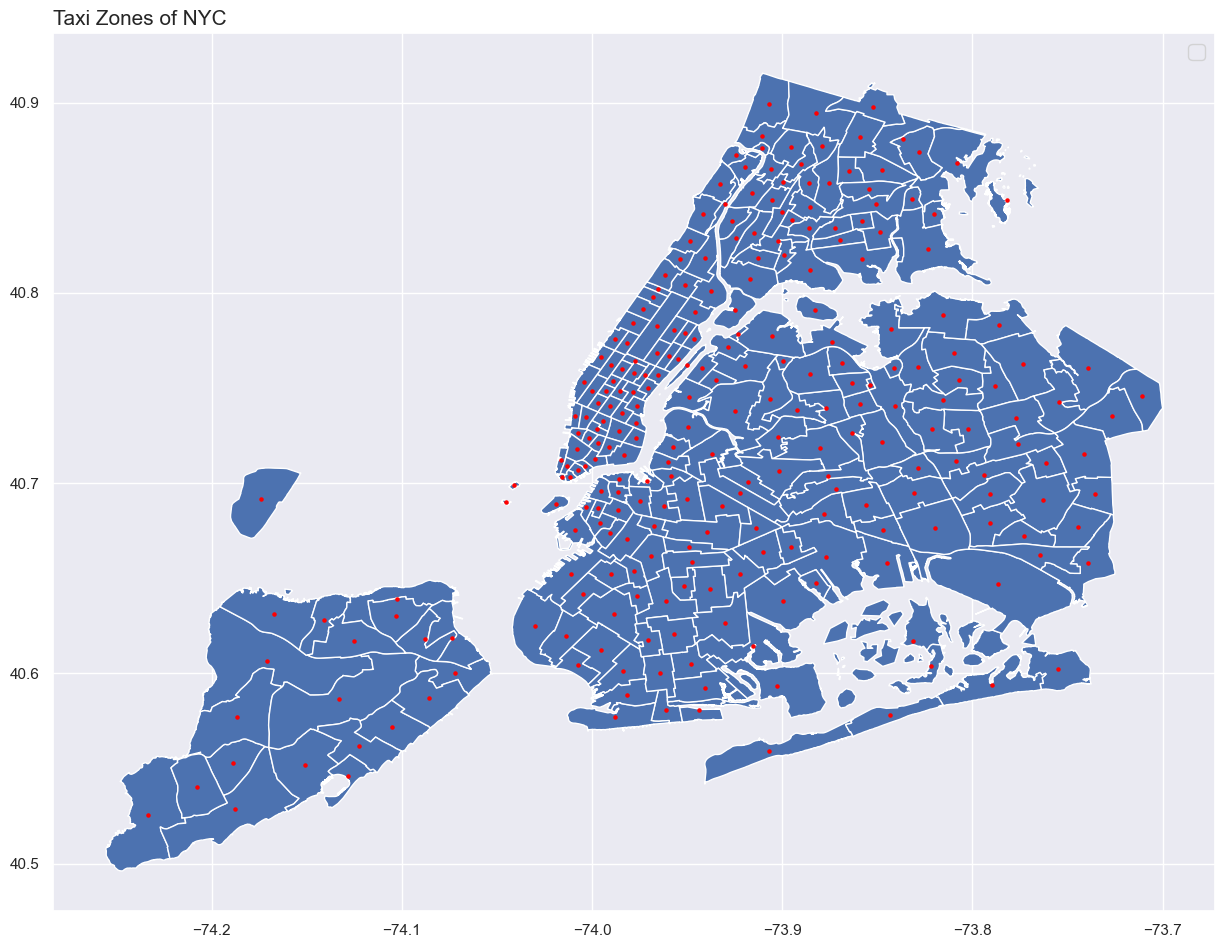

In [166]:
fig, ax = plt.subplots(figsize=(15,15))
taxi_zone_map.plot(ax=ax)
plt.title("Taxi Zones of NYC", loc='left', fontsize=15);

taxigeo_df['centroid'].plot(ax=ax, 
           markersize=5, 
           color='red', 
           marker='o', 
           )

plt.legend(prop={'size':15})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


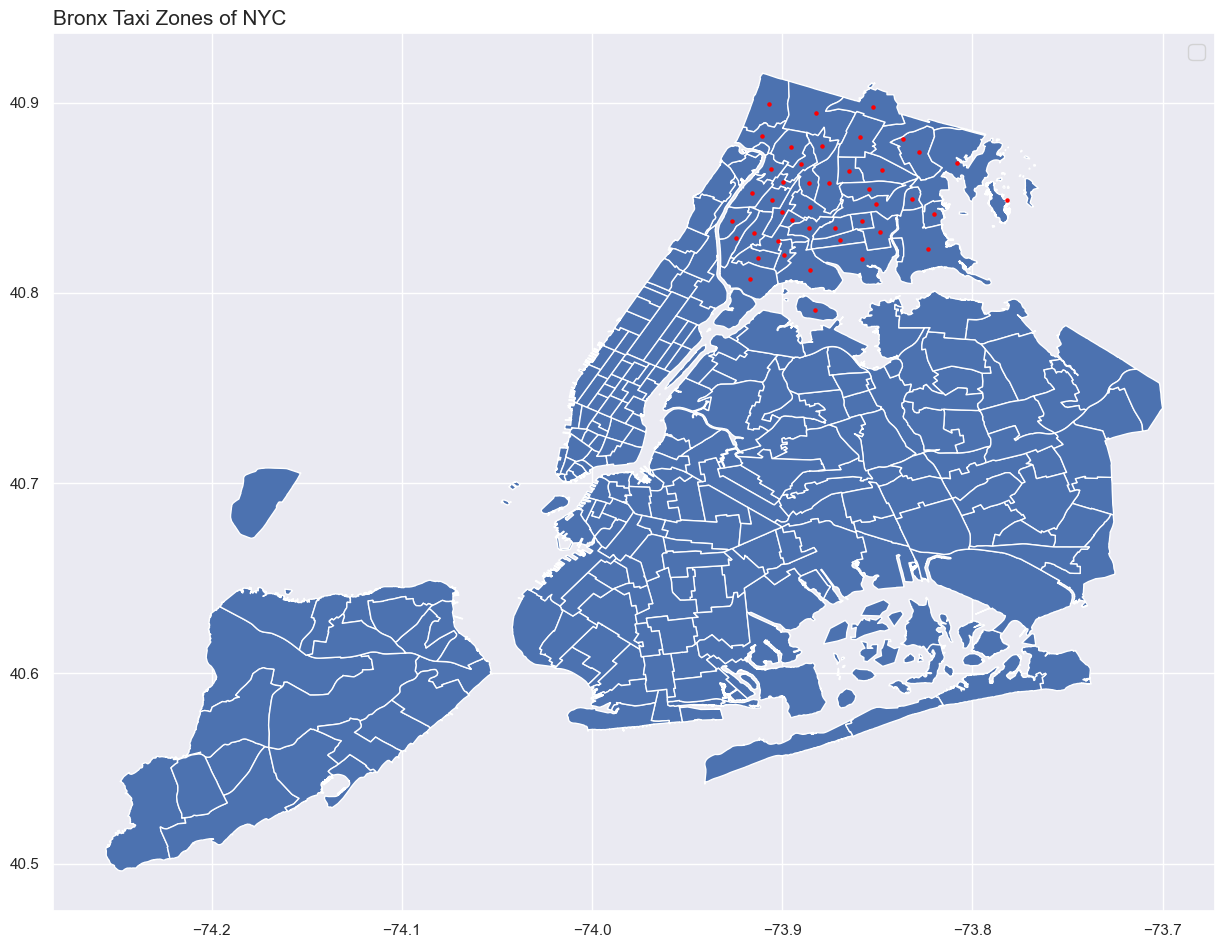

In [168]:
geobronx = taxigeo_df[taxigeo_df['borough'] == 'Bronx']

fig, ax = plt.subplots(figsize=(15,15))
taxi_zone_map.plot(ax=ax)
plt.title("Bronx Taxi Zones of NYC", loc='left', fontsize=15);

geobronx['centroid'].plot(ax=ax, 
           markersize=5, 
           color='red', 
           marker='o', 
           )

plt.legend(prop={'size':15})

In [484]:
df = pd.merge(df, taxigeo_df, on=['zone'], how='left')

In [485]:
df.head()

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough_x,month,day,borough_name,req_hour,trip_duration,the_geom,geometry,centroid,LocationID,borough_y
0,183.0,20.0,4.148,17.69,4.95,12.13,0.00,07:32:00,2022-01-04,07:38:00,2022-01-04,07:53:00,27.6,clear,Pelham Bay,1,1,4,Bronx,7,15.0,MULTIPOLYGON (((-73.83676643699985 40.84338596...,"MULTIPOLYGON (((-73.83677 40.84339, -73.83689 ...",POINT (-73.83158 40.84917),183.0,Bronx
1,262.0,238.0,1.630,10.11,0.00,7.68,2.75,07:15:00,2022-01-04,07:17:00,2022-01-04,07:29:00,27.6,clear,Yorkville East,2,1,4,Manhattan,7,12.0,MULTIPOLYGON (((-73.94383256699986 40.78285908...,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",POINT (-73.94651 40.77593),262.0,Manhattan
2,50.0,161.0,1.751,10.05,2.00,7.85,2.75,07:15:00,2022-01-04,07:23:00,2022-01-04,07:32:00,27.6,clear,Clinton West,2,1,4,Manhattan,7,9.0,MULTIPOLYGON (((-73.99667705784736 40.77351005...,"MULTIPOLYGON (((-73.99668 40.77351, -73.99434 ...",POINT (-73.99514 40.76624),50.0,Manhattan
3,124.0,124.0,1.633,10.76,0.00,5.47,0.00,07:15:00,2022-01-04,07:23:00,2022-01-04,07:28:00,27.6,clear,Howard Beach,3,1,4,Queens,7,5.0,MULTIPOLYGON (((-73.850964537 40.6717195109998...,"MULTIPOLYGON (((-73.85096 40.67172, -73.84848 ...",POINT (-73.84492 40.65825),124.0,Queens
4,180.0,63.0,6.070,24.41,0.00,16.33,0.00,07:15:00,2022-01-04,07:19:00,2022-01-04,07:38:00,27.6,clear,Ozone Park,3,1,4,Queens,7,19.0,MULTIPOLYGON (((-73.8411960569998 40.683351365...,"MULTIPOLYGON (((-73.84120 40.68335, -73.84013 ...",POINT (-73.84704 40.67559),180.0,Queens


In [486]:
df = df.rename(columns={'borough_x': 'borough'})
df.head()

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,month,day,borough_name,req_hour,trip_duration,the_geom,geometry,centroid,LocationID,borough_y
0,183.0,20.0,4.148,17.69,4.95,12.13,0.00,07:32:00,2022-01-04,07:38:00,2022-01-04,07:53:00,27.6,clear,Pelham Bay,1,1,4,Bronx,7,15.0,MULTIPOLYGON (((-73.83676643699985 40.84338596...,"MULTIPOLYGON (((-73.83677 40.84339, -73.83689 ...",POINT (-73.83158 40.84917),183.0,Bronx
1,262.0,238.0,1.630,10.11,0.00,7.68,2.75,07:15:00,2022-01-04,07:17:00,2022-01-04,07:29:00,27.6,clear,Yorkville East,2,1,4,Manhattan,7,12.0,MULTIPOLYGON (((-73.94383256699986 40.78285908...,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",POINT (-73.94651 40.77593),262.0,Manhattan
2,50.0,161.0,1.751,10.05,2.00,7.85,2.75,07:15:00,2022-01-04,07:23:00,2022-01-04,07:32:00,27.6,clear,Clinton West,2,1,4,Manhattan,7,9.0,MULTIPOLYGON (((-73.99667705784736 40.77351005...,"MULTIPOLYGON (((-73.99668 40.77351, -73.99434 ...",POINT (-73.99514 40.76624),50.0,Manhattan
3,124.0,124.0,1.633,10.76,0.00,5.47,0.00,07:15:00,2022-01-04,07:23:00,2022-01-04,07:28:00,27.6,clear,Howard Beach,3,1,4,Queens,7,5.0,MULTIPOLYGON (((-73.850964537 40.6717195109998...,"MULTIPOLYGON (((-73.85096 40.67172, -73.84848 ...",POINT (-73.84492 40.65825),124.0,Queens
4,180.0,63.0,6.070,24.41,0.00,16.33,0.00,07:15:00,2022-01-04,07:19:00,2022-01-04,07:38:00,27.6,clear,Ozone Park,3,1,4,Queens,7,19.0,MULTIPOLYGON (((-73.8411960569998 40.683351365...,"MULTIPOLYGON (((-73.84120 40.68335, -73.84013 ...",POINT (-73.84704 40.67559),180.0,Queens


In [487]:
df = df.drop(columns=(['the_geom', 'geometry']))
df.head()

,PULocationID,DOLocationID,trip_miles,base_passenger_fare,tips,driver_pay,congestion_surcharge,req_time,req_date,pickup_time,dropoff_date,dropoff_time,temp,preciptype,zone,borough,month,day,borough_name,req_hour,trip_duration,centroid,LocationID,borough_y
0,183.0,20.0,4.148,17.69,4.95,12.13,0.00,07:32:00,2022-01-04,07:38:00,2022-01-04,07:53:00,27.6,clear,Pelham Bay,1,1,4,Bronx,7,15.0,POINT (-73.83158 40.84917),183.0,Bronx
1,262.0,238.0,1.630,10.11,0.00,7.68,2.75,07:15:00,2022-01-04,07:17:00,2022-01-04,07:29:00,27.6,clear,Yorkville East,2,1,4,Manhattan,7,12.0,POINT (-73.94651 40.77593),262.0,Manhattan
2,50.0,161.0,1.751,10.05,2.00,7.85,2.75,07:15:00,2022-01-04,07:23:00,2022-01-04,07:32:00,27.6,clear,Clinton West,2,1,4,Manhattan,7,9.0,POINT (-73.99514 40.76624),50.0,Manhattan
3,124.0,124.0,1.633,10.76,0.00,5.47,0.00,07:15:00,2022-01-04,07:23:00,2022-01-04,07:28:00,27.6,clear,Howard Beach,3,1,4,Queens,7,5.0,POINT (-73.84492 40.65825),124.0,Queens
4,180.0,63.0,6.070,24.41,0.00,16.33,0.00,07:15:00,2022-01-04,07:19:00,2022-01-04,07:38:00,27.6,clear,Ozone Park,3,1,4,Queens,7,19.0,POINT (-73.84704 40.67559),180.0,Queens


In [489]:
df = df.drop(columns=(['borough_y']))
df.to_csv('../data/geotaxi2022.csv')

In [492]:
taxigeo_df.head(5)

,the_geom,geometry,centroid,zone,LocationID,borough
0,MULTIPOLYGON (((-74.18445299999996 40.69499599...,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",POINT (-74.17400 40.69183),Newark Airport,1,EWR
1,MULTIPOLYGON (((-73.82337597260663 40.63898704...,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.83130 40.61675),Jamaica Bay,2,Queens
2,MULTIPOLYGON (((-73.84792614099985 40.87134223...,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",POINT (-73.84742 40.86447),Allerton/Pelham Gardens,3,Bronx
3,MULTIPOLYGON (((-73.97177410965318 40.72582128...,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...",POINT (-73.97697 40.72375),Alphabet City,4,Manhattan
4,MULTIPOLYGON (((-74.17421738099989 40.56256808...,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...",POINT (-74.18848 40.55266),Arden Heights,5,Staten Island


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


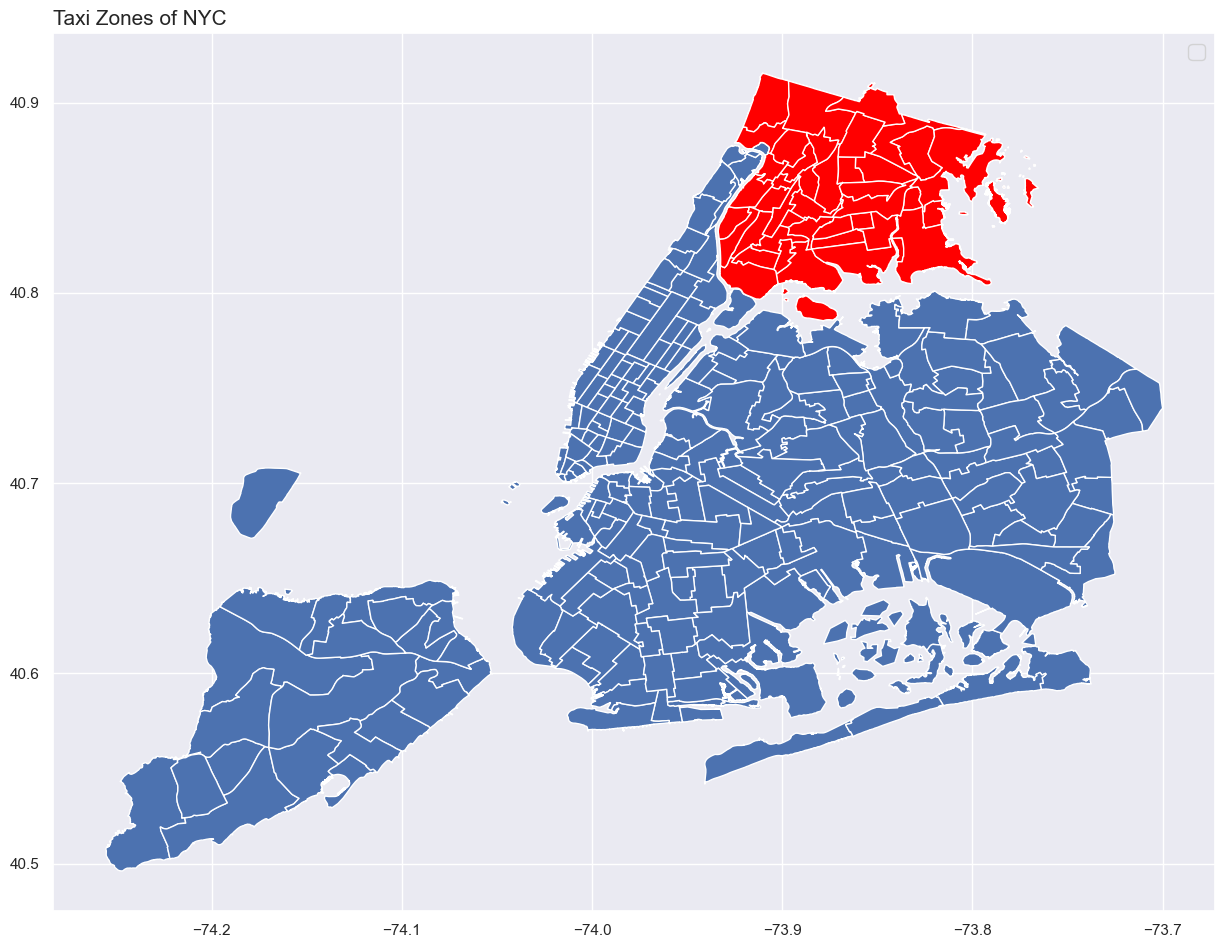

In [493]:
fig, ax = plt.subplots(figsize=(15,15))
taxi_zone_map.plot(ax=ax)
plt.title("Taxi Zones of NYC", loc='left', fontsize=15);


taxigeo_df[taxigeo_df['borough'] == 'Bronx'].plot(ax=ax, 
           markersize=5, 
           color='red', 
           marker='o', 
           )

plt.legend(prop={'size':15})

In [496]:
df['geometry'] = gpd.GeoSeries.from_wkt(taxi_zone_points['the_geom'])
taxigeo_df2 = gpd.GeoDataFrame(df, geometry='geometry')
taxigeo_df2['centroid'] = taxigeo_df2['geometry'].centroid

type(taxigeo_df2)

geopandas.geodataframe.GeoDataFrame